In [1]:

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Ellipse, Circle
from astropy.io import ascii, fits
from astropy.wcs import WCS, utils
from astropy.table import Table
#from astropy.stats import knuth_bin_width, histogram, bayesian_blocks
from lmfit import minimize, Minimizer, report_fit, Model, Parameters
import lmfit
import pandas as pd
#from ipywidgets import FloatProgress
from IPython.display import display
from MUSE_Models import MUSE_3D_OIII, MUSE_3D_residual, PNe_spectrum_extractor, PNextractor, PSF_residuals, data_cube_y_x
import yaml
%config InlineBackend.figure_format = 'retina'

0.9 arcsec FWHM and 0.135 arcsec/pixel

In [2]:
# functions
# Open Fits file and assign to raw_data

hdulist = fits.open("FCC167_data/FCC167_emission_cube.fits")

hdr = hdulist[0].header

y_data, x_data, n_data = data_cube_y_x(len(hdulist[0].data))

wavelength = np.load("FCC167_data/FCC167_wavelength.npy")

#Read in x and y coordinates
x_y_list = np.load("exported_data/FCC167/PNe_x_y_list.npy")
x_PNe = np.array([x[0] for x in x_y_list])
y_PNe = np.array([y[1] for y in x_y_list])

n_pixels= 7
z = 0.006261
c = 299792458.0

coordinates = [(n,m) for n in range(n_pixels) for m in range(n_pixels)]
x_fit = np.array([item[0] for item in coordinates])
y_fit = np.array([item[1] for item in coordinates])

# Retrieve the respective spectra for each PNe source
PNe_spectra = np.array([PNe_spectrum_extractor(x, y, n_pixels, hdulist[0].data, x_data, wave=wavelength) for x,y in zip(x_PNe, y_PNe)])
#PNe_spectra = np.array([new_extractor(x, y, n_pixels, raw_data_cube, wave=wavelength, dim=2.0) for x,y in zip(x_PNe, y_PNe)])

# create Pandas data frame for values
PNe_df = pd.DataFrame(columns=("PNe number", "Ra (J2000)", "Dec (J2000)", "Total Flux", "Flux error", "V (km/s)", "m 5007", "M 5007", "M 5007 error","A/rN", "rad D", "Chi^2"))
PNe_df["PNe number"] = np.arange(0,len(x_PNe)) # PNe numbers
PNe_df["rad D"] = [np.sqrt((x-x_data/2.)**2 + (y - y_data/2.)**2) for x,y in zip(x_PNe, y_PNe)] # Radial distance, in pixels, from the centre of pointing
# .loc(Row, column name)

## Ra and Dec
#hdu_wcs = fits.open("FCC167_data/FCC167_center_DATACUBE_CLEANED.fits")
#hdr_wcs = hdu_wcs[1].header
#wcs_obj = WCS(hdr_wcs, naxis=2)
#
#for i in np.arange(0, len(x_PNe)):
#    Ra_Dec = utils.pixel_to_skycoord(x_PNe[i],y_PNe[i], wcs_obj).to_string("hmsdms").split()
#    PNe_df.loc[i,"Ra (J2000)"] = Ra_Dec[0]
#    PNe_df.loc[i,"Dec (J2000)"] = Ra_Dec[1]

# Objective Residual Cube
#obj_residual_cube = fits.open("exported_data/FCC167/resids_obj.fits")#np.load("exported_data/FCC167/resids_obj.npy")

# Data Residual Cube
#residual_cube = fits.open("exported_data/FCC167/resids_data.fits")#np.load("exported_data/FCC167/resids_data.npy")

def uncertainty_cube_construct(data, x_P, y_P, n_pix):
    data[data == np.inf] = 0.01
    extract_data = np.array([PNe_spectrum_extractor(x, y, n_pix, data, x_data, wave=wavelength) for x,y in zip(x_P, y_P)])
    array_to_fill = np.zeros((len(x_P), n_pix*n_pix, len(wavelength)))
    for p in np.arange(0, len(x_P)):
        list_of_std = np.abs(np.std(extract_data[p], 1))
        array_to_fill[p] = [np.repeat(list_of_std[i], len(wavelength)) for i in np.arange(0, len(list_of_std))]
  
    return array_to_fill

#error_cube = uncertainty_cube_construct(residual_cube[0].data, x_PNe, y_PNe, n_pixels)
#obj_error_cube = uncertainty_cube_construct(obj_residual_cube[0].data, x_PNe, y_PNe, n_pixels)

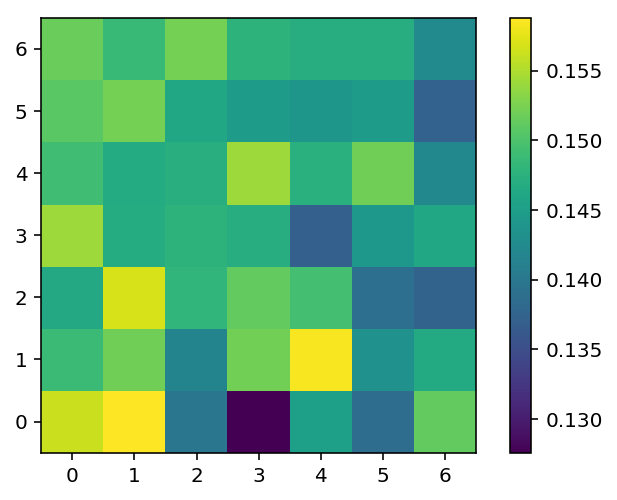

In [17]:
#plt.figure()
#plt.imshow(1/obj_error_cube[25][:,0].reshape(n_pixels,n_pixels), origin="lower")
#plt.colorbar()

plt.figure()
plt.imshow(1/error_cube[13][:,0].reshape(n_pixels,n_pixels), origin="lower")
plt.colorbar()

# 3D fitting routine

$$ f(x,y) = A \Big(1+ \frac{(x - x_0)^2 + (y - y_0)^2}{\gamma^2}\Big)^{-\beta} $$

(-2000, 4000)

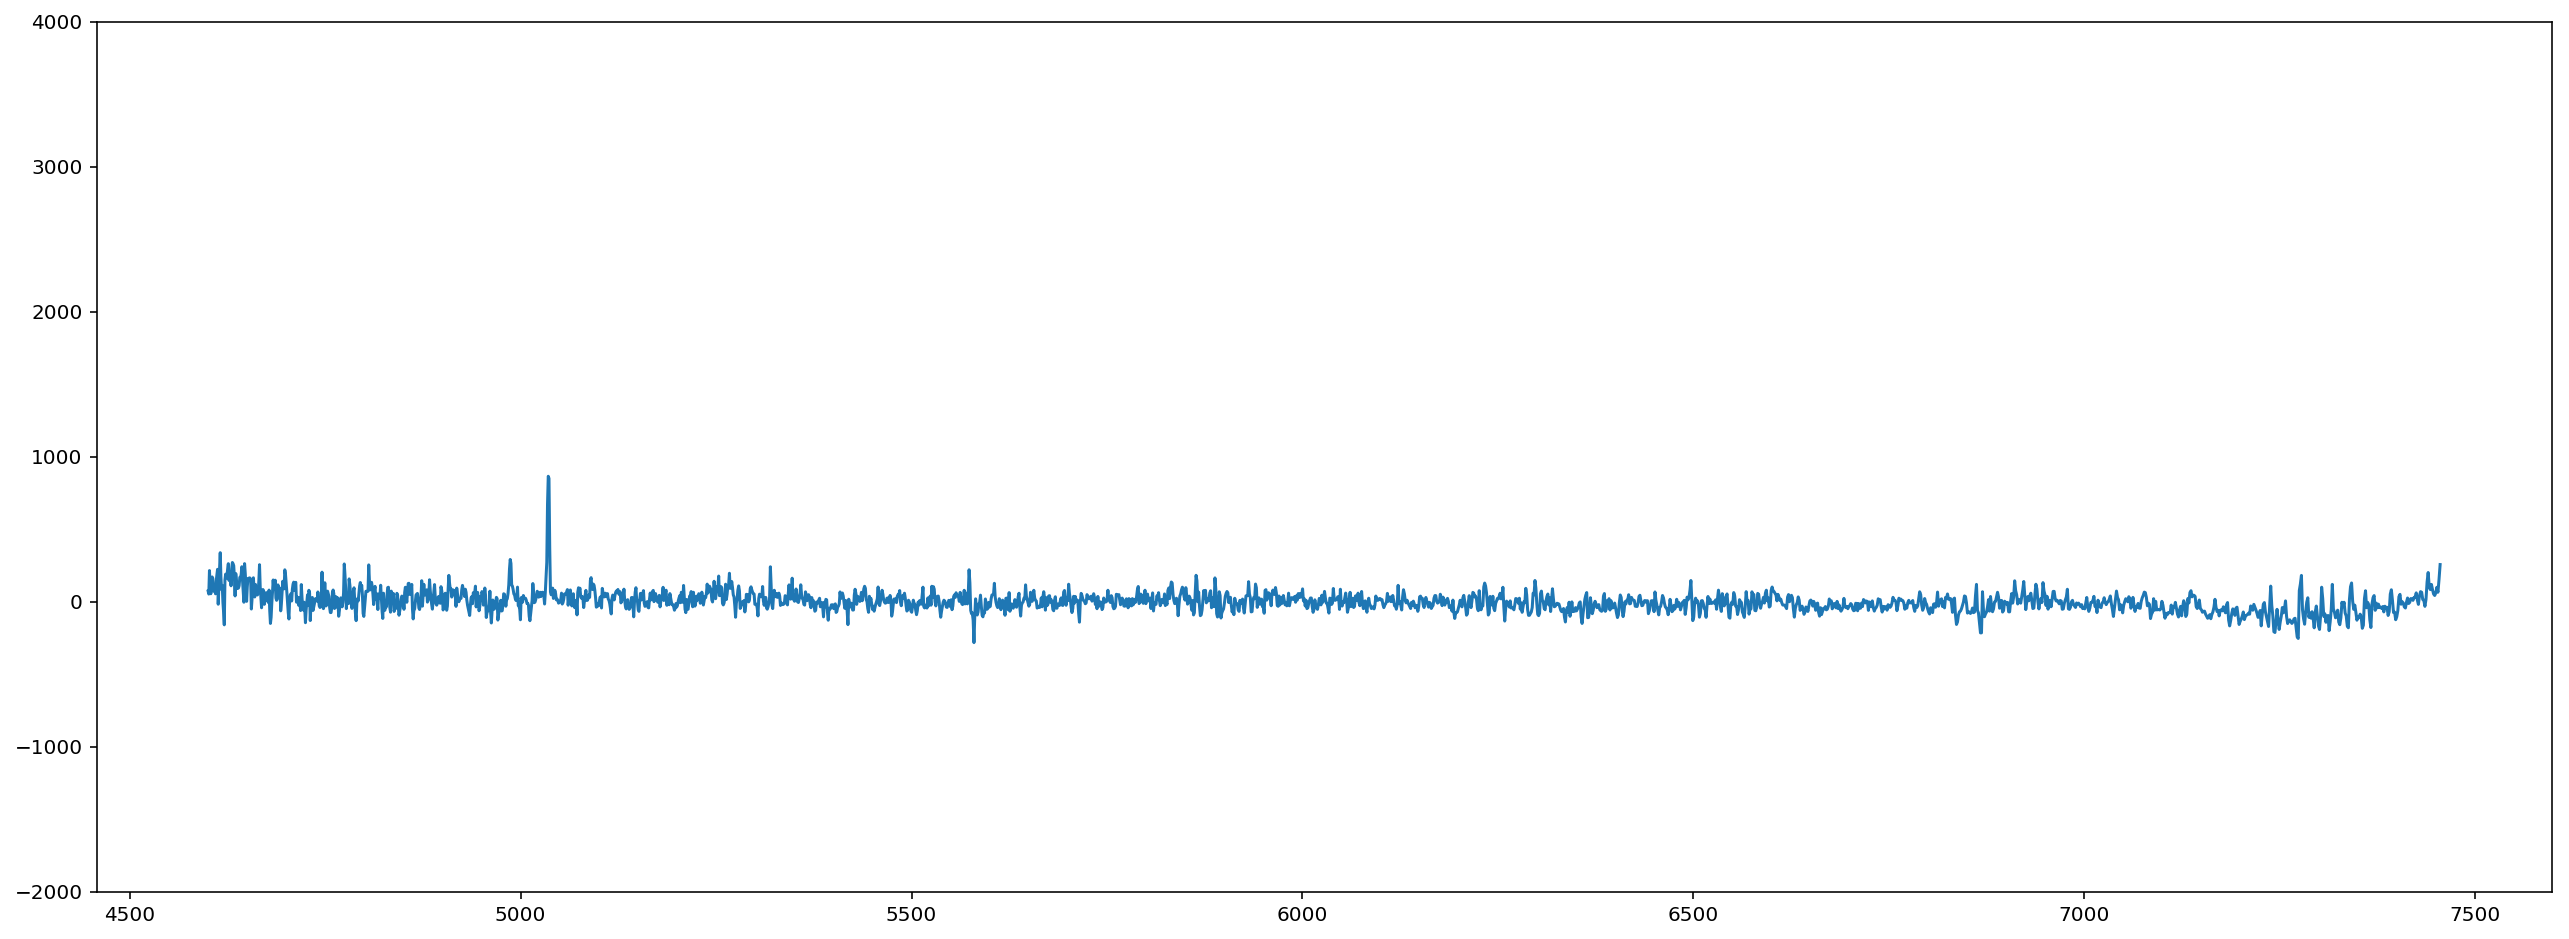

In [6]:
plt.figure(figsize=(22,8))
plt.plot(wavelength, np.sum(PNe_spectra[20], 0)) #213, 142
#plt.plot(wavelength, np.sum(PNextractor(213, 142, 7, raw_data_cube, wave=wavelength, dim=2.0),0))
plt.ylim(-2000,4000)
#plt.xlim(4900,5100)
#plt.axvline(5020)
#plt.savefig("Plots/for_pablo.png")
#print(np.std(np.sum(PNextractor(213, 142, 7, raw_data_cube, wave=wavelength, dim=2.0),0)))

In [16]:
# Parameter setup

PNe_params = Parameters()
PNe_params.add('Amp_2D', value=100., min=0.01)
PNe_params.add('x_0', value=(n_pixels/2.), min=0.01, max=n_pixels)
PNe_params.add('y_0', value=(n_pixels/2.), min=0.01, max=n_pixels)
PNe_params.add("M_FWHM", value=4.0, min=3.4, max=4.2, vary=False)
PNe_params.add("beta", value=2.5, min=2.6, max=3.0, vary=False) #1.46
PNe_params.add("wave", value=5035., min=5000., max=5070.)
PNe_params.add("Gauss_bkg",  value=0.001)
PNe_params.add("Gauss_grad", value=0.001)

FWHM_in_err = 0.2921
beta_in_err = 0.7567

#4.7863813596549436
#2.2710857136431621


#3.477154047381648
#2.545797591806868

## Fitting routine

In [3]:
with open("galaxy_info.yaml", "r") as yaml_data:
    galaxy_info = yaml.load(yaml_data)
    
galaxy_data = galaxy_info["FCC167"]

emission_dict = galaxy_data["emissions"]

D = galaxy_data["Distance"]

PNe_multi_params = Parameters()

def gen_params(wave=5007, FWHM=4.0, beta=2.5, em_dict=None):
    # loop through emission dictionary to add different element parameters 
    for em in em_dict:
        #Amplitude params for each emission
        PNe_multi_params.add('Amp_2D_{}'.format(em), value=emission_dict[em][0], min=0.01, expr=emission_dict[em][1])
        #Wavelength params for each emission
        if emission_dict[em][2] == None:
            PNe_multi_params.add("wave_{}".format(em), value=wave, min=wave-40., max=wave+40.)
        else:
            PNe_multi_params.add("wave_{}".format(em), expr=emission_dict[em][2].format(z))
    
    PNe_multi_params.add('x_0', value=(n_pixels/2.), min=0.01, max=n_pixels)
    PNe_multi_params.add('y_0', value=(n_pixels/2.), min=0.01, max=n_pixels)
    PNe_multi_params.add("M_FWHM", value=FWHM, vary=False)
    PNe_multi_params.add("beta", value=beta, vary=False)   
    PNe_multi_params.add("Gauss_bkg",  value=0.00001)
    PNe_multi_params.add("Gauss_grad", value=0.00001)

# generate parameters with values
gen_params(wave=5007.*(1+z), em_dict=emission_dict)

# useful value storage setup
total_Flux = np.zeros((len(x_PNe),len(emission_dict)))
A_2D_list = np.zeros((len(x_PNe),len(emission_dict)))
F_xy_list = np.zeros((len(x_PNe), len(emission_dict), len(PNe_spectra[0])))
emission_amp_list = np.zeros((len(x_PNe),len(emission_dict)))
model_spectra_list = np.zeros((len(x_PNe), n_pixels*n_pixels, len(wavelength)))
mean_wave_list = np.zeros((len(x_PNe),len(emission_dict)))
residuals_list = np.zeros(len(x_PNe))
list_of_fit_residuals = np.zeros((len(x_PNe), n_pixels*n_pixels, len(wavelength)))
chi_2_r = np.zeros((len(x_PNe)))

# error lists
moff_A_err = np.zeros((len(x_PNe), len(emission_dict)))
x_0_err = np.zeros((len(x_PNe), len(emission_dict)))
y_0_err = np.zeros((len(x_PNe), len(emission_dict)))
mean_wave_err = np.zeros((len(x_PNe), len(emission_dict)))
Gauss_bkg_err = np.zeros((len(x_PNe), len(emission_dict)))
Gauss_grad_err = np.zeros((len(x_PNe), len(emission_dict)))

FWHM_list = np.zeros(len(x_PNe))
list_of_x = np.zeros(len(x_PNe))
list_of_y = np.zeros(len(x_PNe))
Gauss_bkg = np.zeros(len(x_PNe))
Gauss_grad = np.zeros(len(x_PNe))


def log_10(x):
    return np.log10(x)

def run_minimiser(parameters):
    for PNe_num in np.arange(0, len(x_PNe)):
        useful_stuff = []
        #run minimizer fitting routine
        multi_fit_results = minimize(MUSE_3D_residual, PNe_multi_params, args=(wavelength, x_fit, y_fit, PNe_spectra[PNe_num], np.ones_like(PNe_spectra[PNe_num]), PNe_num, "full", emission_dict, useful_stuff), nan_policy="propagate")
        total_Flux[PNe_num] = np.sum(useful_stuff[1][1],1) * 1e-20
        list_of_fit_residuals[PNe_num] = useful_stuff[0]
        A_2D_list[PNe_num] = useful_stuff[1][0]
        F_xy_list[PNe_num] = useful_stuff[1][1]
        model_spectra_list[PNe_num] = useful_stuff[1][3]
        emission_amp_list[PNe_num] = [multi_fit_results.params["Amp_2D_{}".format(em)] for em in emission_dict]
        mean_wave_list[PNe_num] = [multi_fit_results.params["wave_{}".format(em)] for em in emission_dict]   
        chi_2_r[PNe_num] = multi_fit_results.redchi
        list_of_x[PNe_num] = multi_fit_results.params["x_0"]
        list_of_y[PNe_num] = multi_fit_results.params["y_0"]
        Gauss_bkg[PNe_num] = multi_fit_results.params["Gauss_bkg"]
        Gauss_grad[PNe_num] = multi_fit_results.params["Gauss_grad"]
        #save errors
        moff_A_err[PNe_num] = [multi_fit_results.params["Amp_2D_{}".format(em)] for em in emission_dict]
        mean_wave_err[PNe_num] = [multi_fit_results.params["wave_{}".format(em)] for em in emission_dict]
        x_0_err[PNe_num] = multi_fit_results.params["x_0"].stderr
        y_0_err[PNe_num] = multi_fit_results.params["y_0"].stderr
        Gauss_bkg_err[PNe_num] = multi_fit_results.params["Gauss_bkg"].stderr
        Gauss_grad_err[PNe_num] = multi_fit_results.params["Gauss_grad"].stderr

    # Signal to noise and Magnitude calculations
    list_of_rN = np.array([np.std(PNe_res) for PNe_res in list_of_fit_residuals])
    PNe_df["A/rN"] = A_2D_list[:,0] / list_of_rN # Using OIII amplitude
    
    de_z_means = mean_wave_list[:,0] / (1 + z) # de redshift OIII wavelength position
    
    PNe_df["V (km/s)"] = (c * (de_z_means - 5007.) / 5007.) / 1000.
    
    PNe_df["chi^2"] = chi_2_r
    
    PNe_df["[OIII] Flux"] = total_Flux[:,0] #store total OIII 5007 line flux
    
    PNe_df["[OIII]/Hb"] = PNe_df["[OIII] Flux"] / total_Flux[:,2] # store OIII/Hb ratio
    
    def log_10(x):
        return np.log10(x)
    
    PNe_df["m 5007"] = -2.5 * PNe_df["[OIII] Flux"].apply(log_10) - 13.74
    dM =  5. * np.log10(D) + 25.   # 31.63
    PNe_df["M 5007"] = PNe_df["m 5007"] - dM
    
    Dist_est = 10.**(((PNe_df["m 5007"].min() + 4.5) -25.) / 5.)
    print("Distance Estimate from PNLF: ", Dist_est, "Mpc")


In [4]:
print("Running fitter")
run_minimiser(PNe_multi_params)

Running fitter
Distance Estimate from PNLF:  16.636581187043266 Mpc


In [ ]:
PNe_df.nsmallest(15, "m 5007")

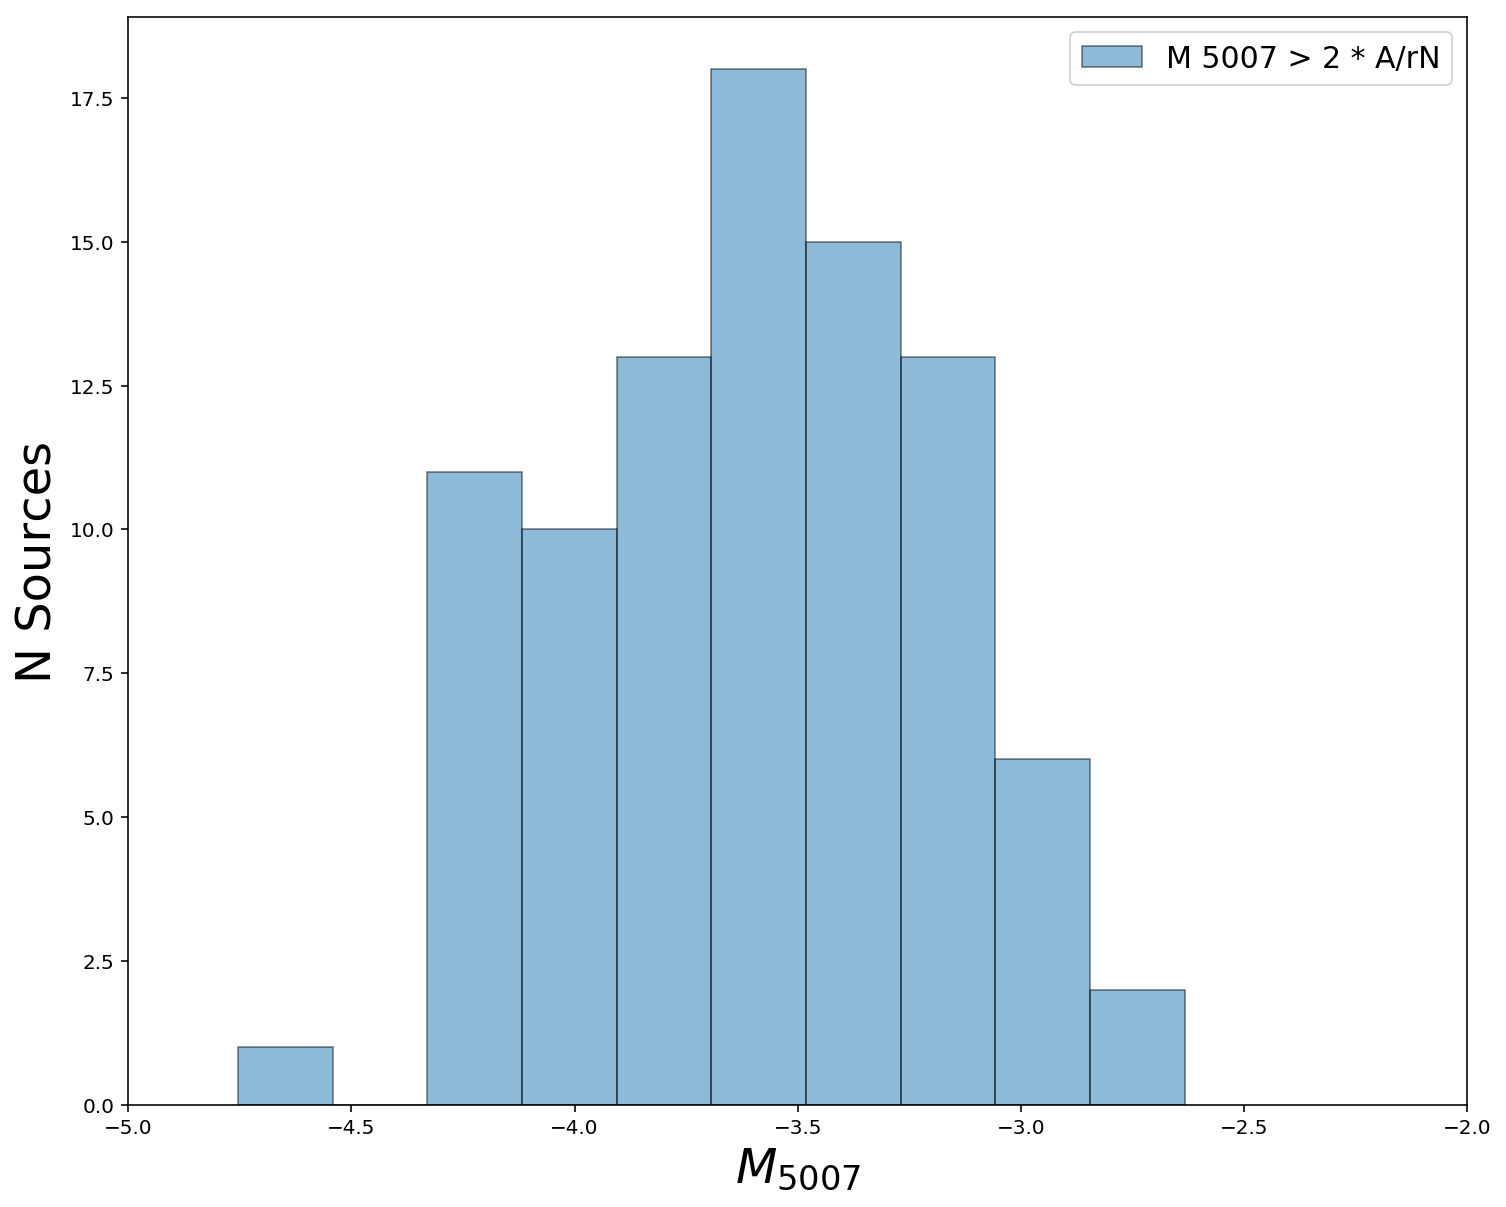

In [25]:
plt.figure(1, figsize=(12,10))
bins, bins_cens, other = plt.hist(PNe_df["M 5007"].loc[PNe_df["A/rN"]>2], bins=10, edgecolor="black", linewidth=0.8, label="M 5007 > 2 * A/rN", alpha=0.5)
#bins, bins_cens, other = plt.hist(PNe_df["M 5007"], bins=16, edgecolor="black",color="green", linewidth=0.8, label="M 5007 > 2 * A/rN", alpha=0.5)

plt.xlim(-5.,-2.0)
plt.xlabel("$M_{5007}$", fontsize=24)
plt.ylabel("N Sources", fontsize=24)
plt.legend(fontsize=15)
#plt.savefig("Plots/"+ galaxy_data["Galaxy name"]+"/M5007_histogram.png")
bins_cens = bins_cens[:-1]

# Filter off for PNe

In [20]:
filtered_PNe_df = PNe_df.loc[(PNe_df["A/rN"]>2) & (PNe_df["[OIII] Flux"]>=1e-18)]
print(len(PNe_df))
print(len(filtered_PNe_df))

90
89


In [35]:
#filtered_PNe_df = PNe_df.loc[PNe_df["Total Flux"]>=1e-19]
len(PNe_df.loc[PNe_df["[OIII] Flux"]>=1e-17])

89

In [1]:
N, bins = histogram(PNe_df["m 5007"].loc[PNe_df["A/rN"]>2], bins=13)
plt.scatter(bins[:-1], np.log10(N))
bin_w = (bins[0] - bins[1])/2
plt.xlim(26.5,28.5)
plt.ylabel("Log($N_{PNe} \ / \ bin)$", fontsize=20)
plt.xlabel("$m_{5007}$", fontsize=20)
plt.errorbar(bins[:-1], np.log10(N) , 0,bin_w, fmt="o")

NameError: name 'histogram' is not defined

Text(0, 0.5, 'Flux')

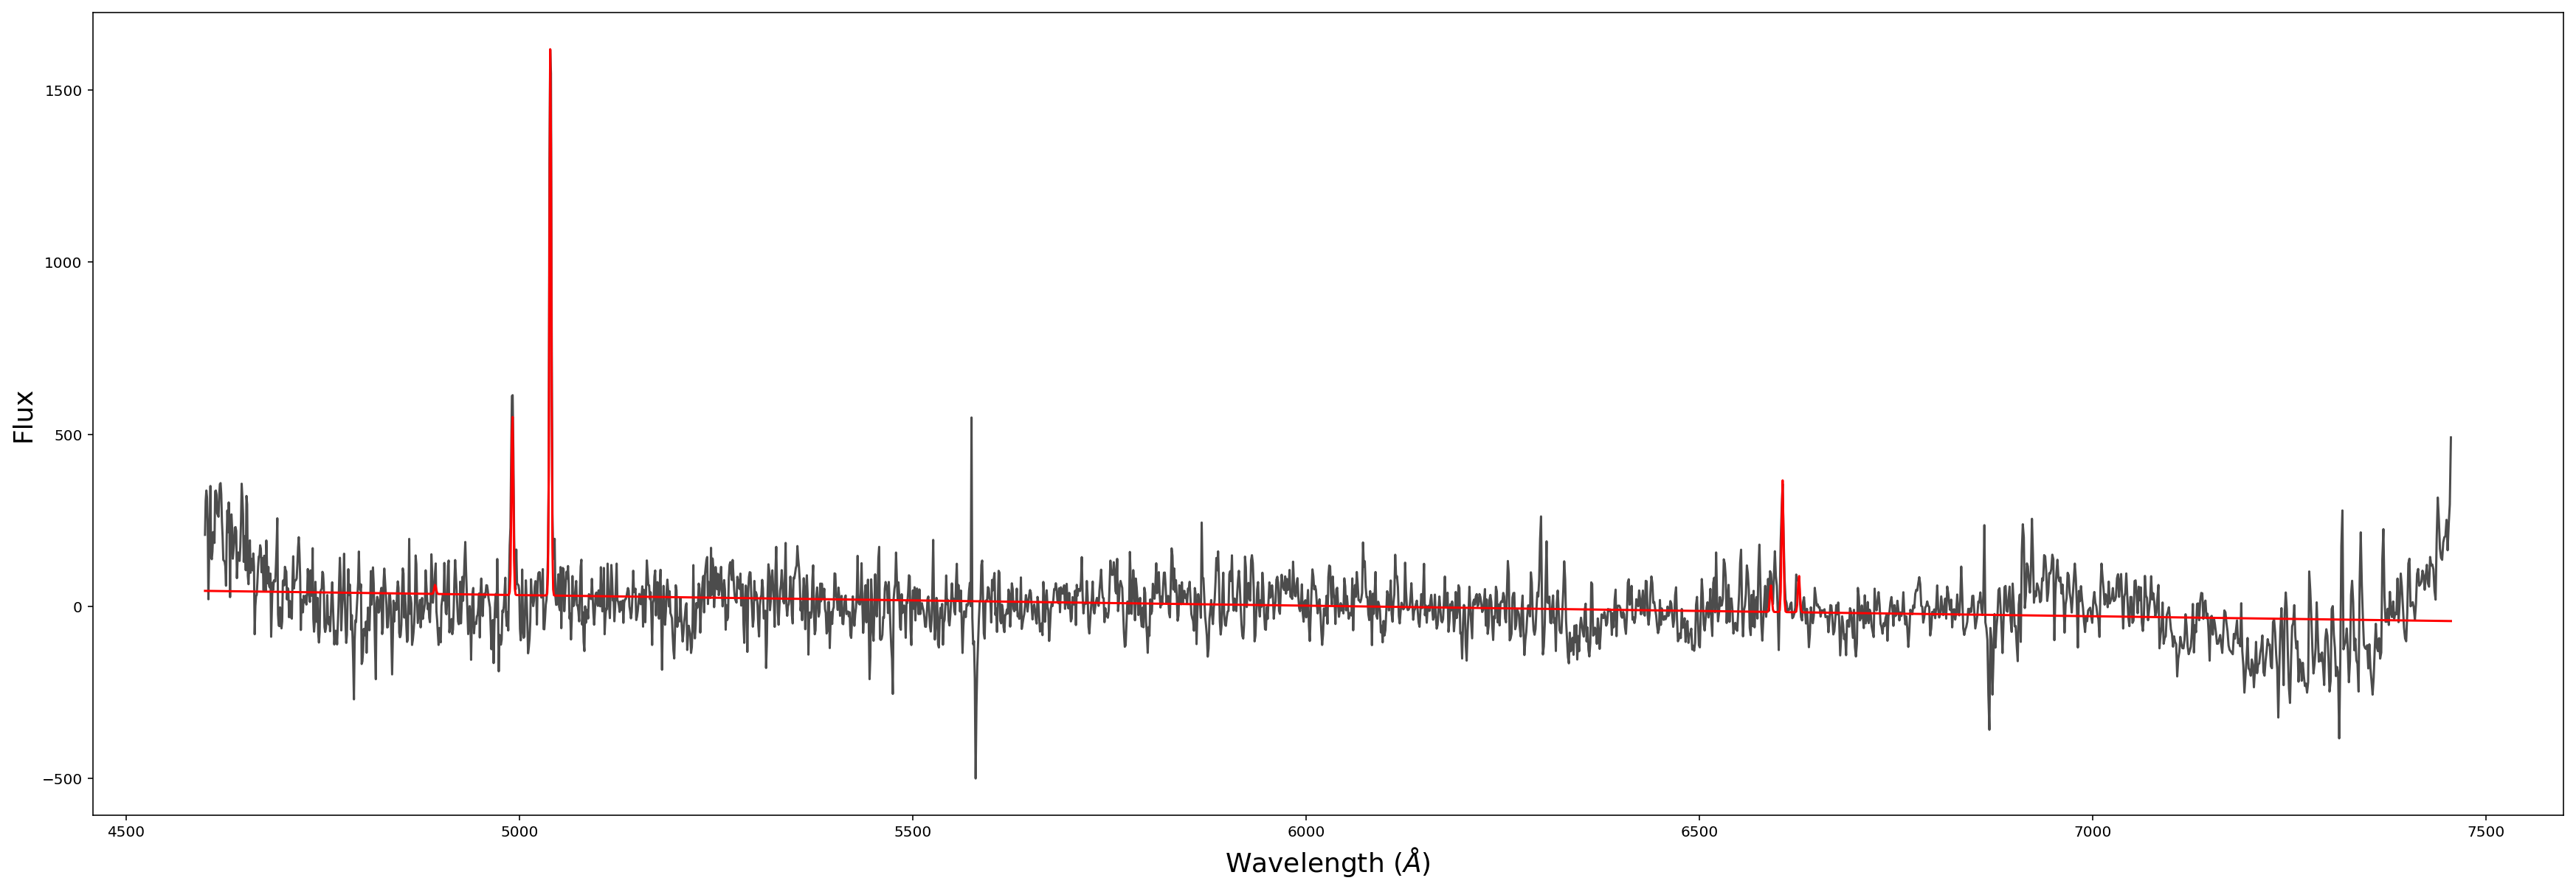

In [47]:
p = 10
plt.figure(figsize=(30,10))
plt.plot(wavelength, np.sum(PNe_spectra[p],0), alpha=0.7, c="k")

plt.plot(wavelength, np.sum(model_spectra_list[p],0), c="r")
plt.xlabel("Wavelength ($\AA$)", fontsize=18)
plt.ylabel("Flux", fontsize=18)

## Aperture selection of PNe spaxels

In [113]:
#Apply circular aperture to total flux
r = 4
integrated_spectra = np.ones((len(x_PNe), len(wavelength)))

Y_circ, X_circ = np.mgrid[:n_pixels, :n_pixels]
for i in np.arange(0, len(x_PNe)):
    PNe_cube = PNe_spectra[i].reshape(n_pixels, n_pixels, len(wavelength))
    circ_mask = (Y_circ-list_of_y[i])**2 + (X_circ-list_of_x[i])**2 <= r*r
    integrated_spectra[i] = np.sum(PNe_cube[circ_mask],0)

stored_models = np.ones((len(x_PNe), len(wavelength)))

def spaxel_by_spaxel(params, x, data, error, spec_num):
    Amp = params["Amp"]
    wave = params["wave"]
    FWHM = params["FWHM"]
    Gauss_bkg = params["Gauss_bkg"]
    Gauss_grad = params["Gauss_grad"]

    Gauss_std = FWHM / 2.35482
    model = ((Gauss_bkg + Gauss_grad * x) + Amp * np.exp(- 0.5 * (x - wave)** 2 / Gauss_std**2.) +
             (Amp/3.) * np.exp(- 0.5 * (x - (wave - 47.9399*(1+z)))** 2 / Gauss_std**2.))
    stored_models[spec_num] = model
    #list_of_rN[spec_num] = np.std(data - model)
    #data_residuals[spec_num] = data - model

    return (data - model) / error


Int_params = Parameters()
Int_params.add('Amp', value=100., min=0.01)
Int_params.add("wave", value=5007.*(1+z), min=5000., max=5070.)
Int_params.add("FWHM", value=2.81, vary=False)
Int_params.add("Gauss_bkg",  value=0.00001)
Int_params.add("Gauss_grad", value=0.00001)

list_of_std = np.abs(np.std(integrated_spectra, 1))
int_spec_err = [np.repeat(item, len(wavelength)) for item in list_of_std]

Int_amp = np.ones((len(x_PNe)))

for i, spec in enumerate(integrated_spectra):
    Int_results = minimize(spaxel_by_spaxel, Int_params, args=(wavelength, spec, int_spec_err[i], i), nan_policy="propagate")
    Int_amp[i] = Int_results.params["Amp"].value

Int_flux = [A * (np.sqrt(2*np.pi) * (2.81 / 2.35482))* 1e-20 for A in Int_amp] 

#print("3D model total Flux in [OIII]", "/n", PNe_df["[OIII] Flux"])
#print("Aperture model total Flux in [OIII]", "/n", Int_flux)



(4900, 5300)

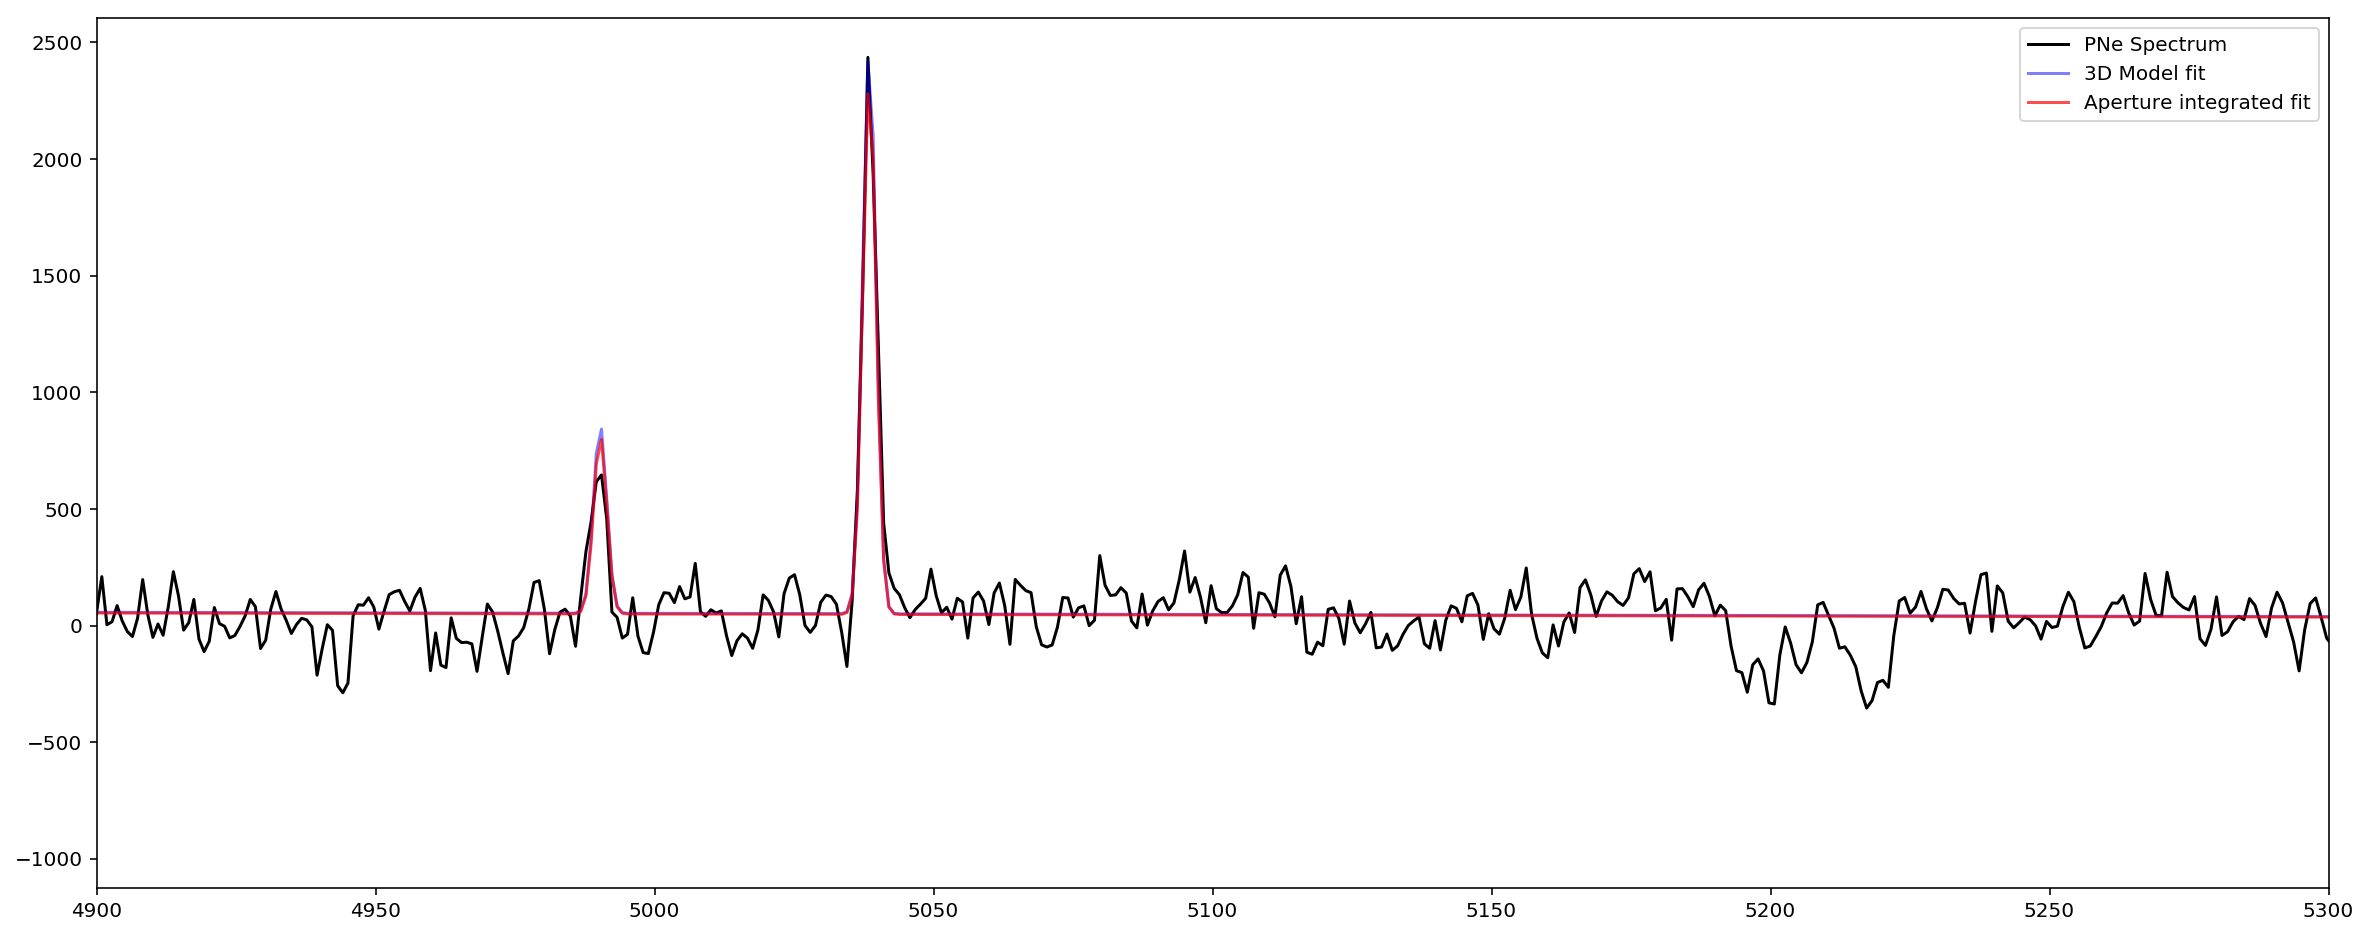

In [119]:
n = 19
plt.figure(figsize=(20,8))
plt.plot(wavelength, np.sum(PNe_spectra[n],0), c="k", label="PNe Spectrum")
plt.plot(wavelength, np.sum(model_spectra_list[n],0), c="b", alpha=0.5, label="3D Model fit")
plt.plot(wavelength, stored_models[n], c="r", alpha=0.7, label="Aperture integrated fit")
plt.legend()
plt.xlim(4900,5300)

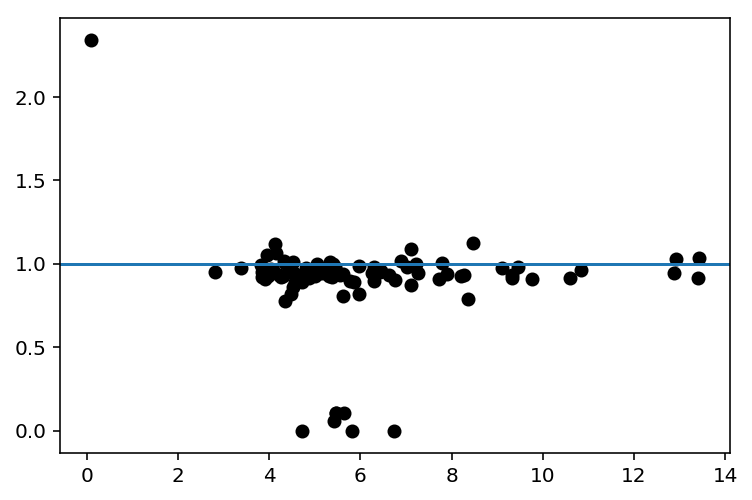

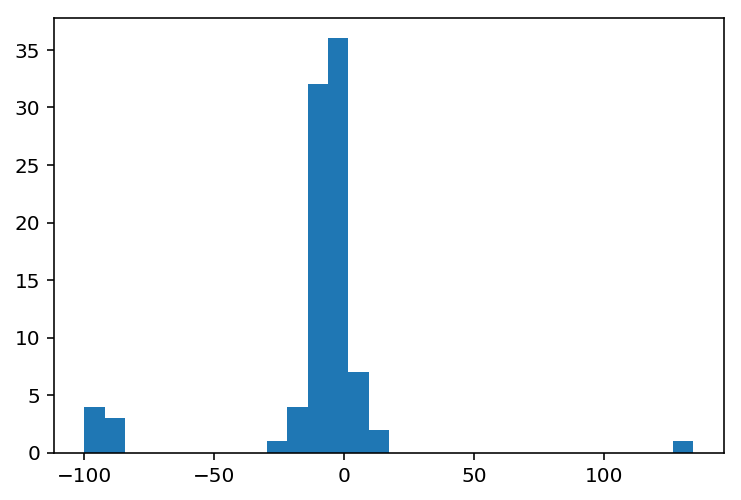

In [114]:
plt.figure()
plt.scatter(PNe_df["A/rN"], (Int_flux / total_Flux[:,0]), c="k" )
plt.axhline(1)

plt.figure()
bins = plt.hist(((Int_flux - total_Flux[:,0])/total_Flux[:,0])*100, bins=30) # 7-10% difference in flux


In [ ]:
for i in np.arange(0, len(x_PNe)):
    print(i, "Aperture Flux: ", Int_flux[i], " / ",
          "3D Model Flux: ", total_Flux[i,0],  " / ",
          "A/rN of 3D model", PNe_df["A/rN"][i], "/",
          "Delta Flux: ", ((Int_flux[i] - total_Flux[i,0])/total_Flux[i,0])*100, "%" )

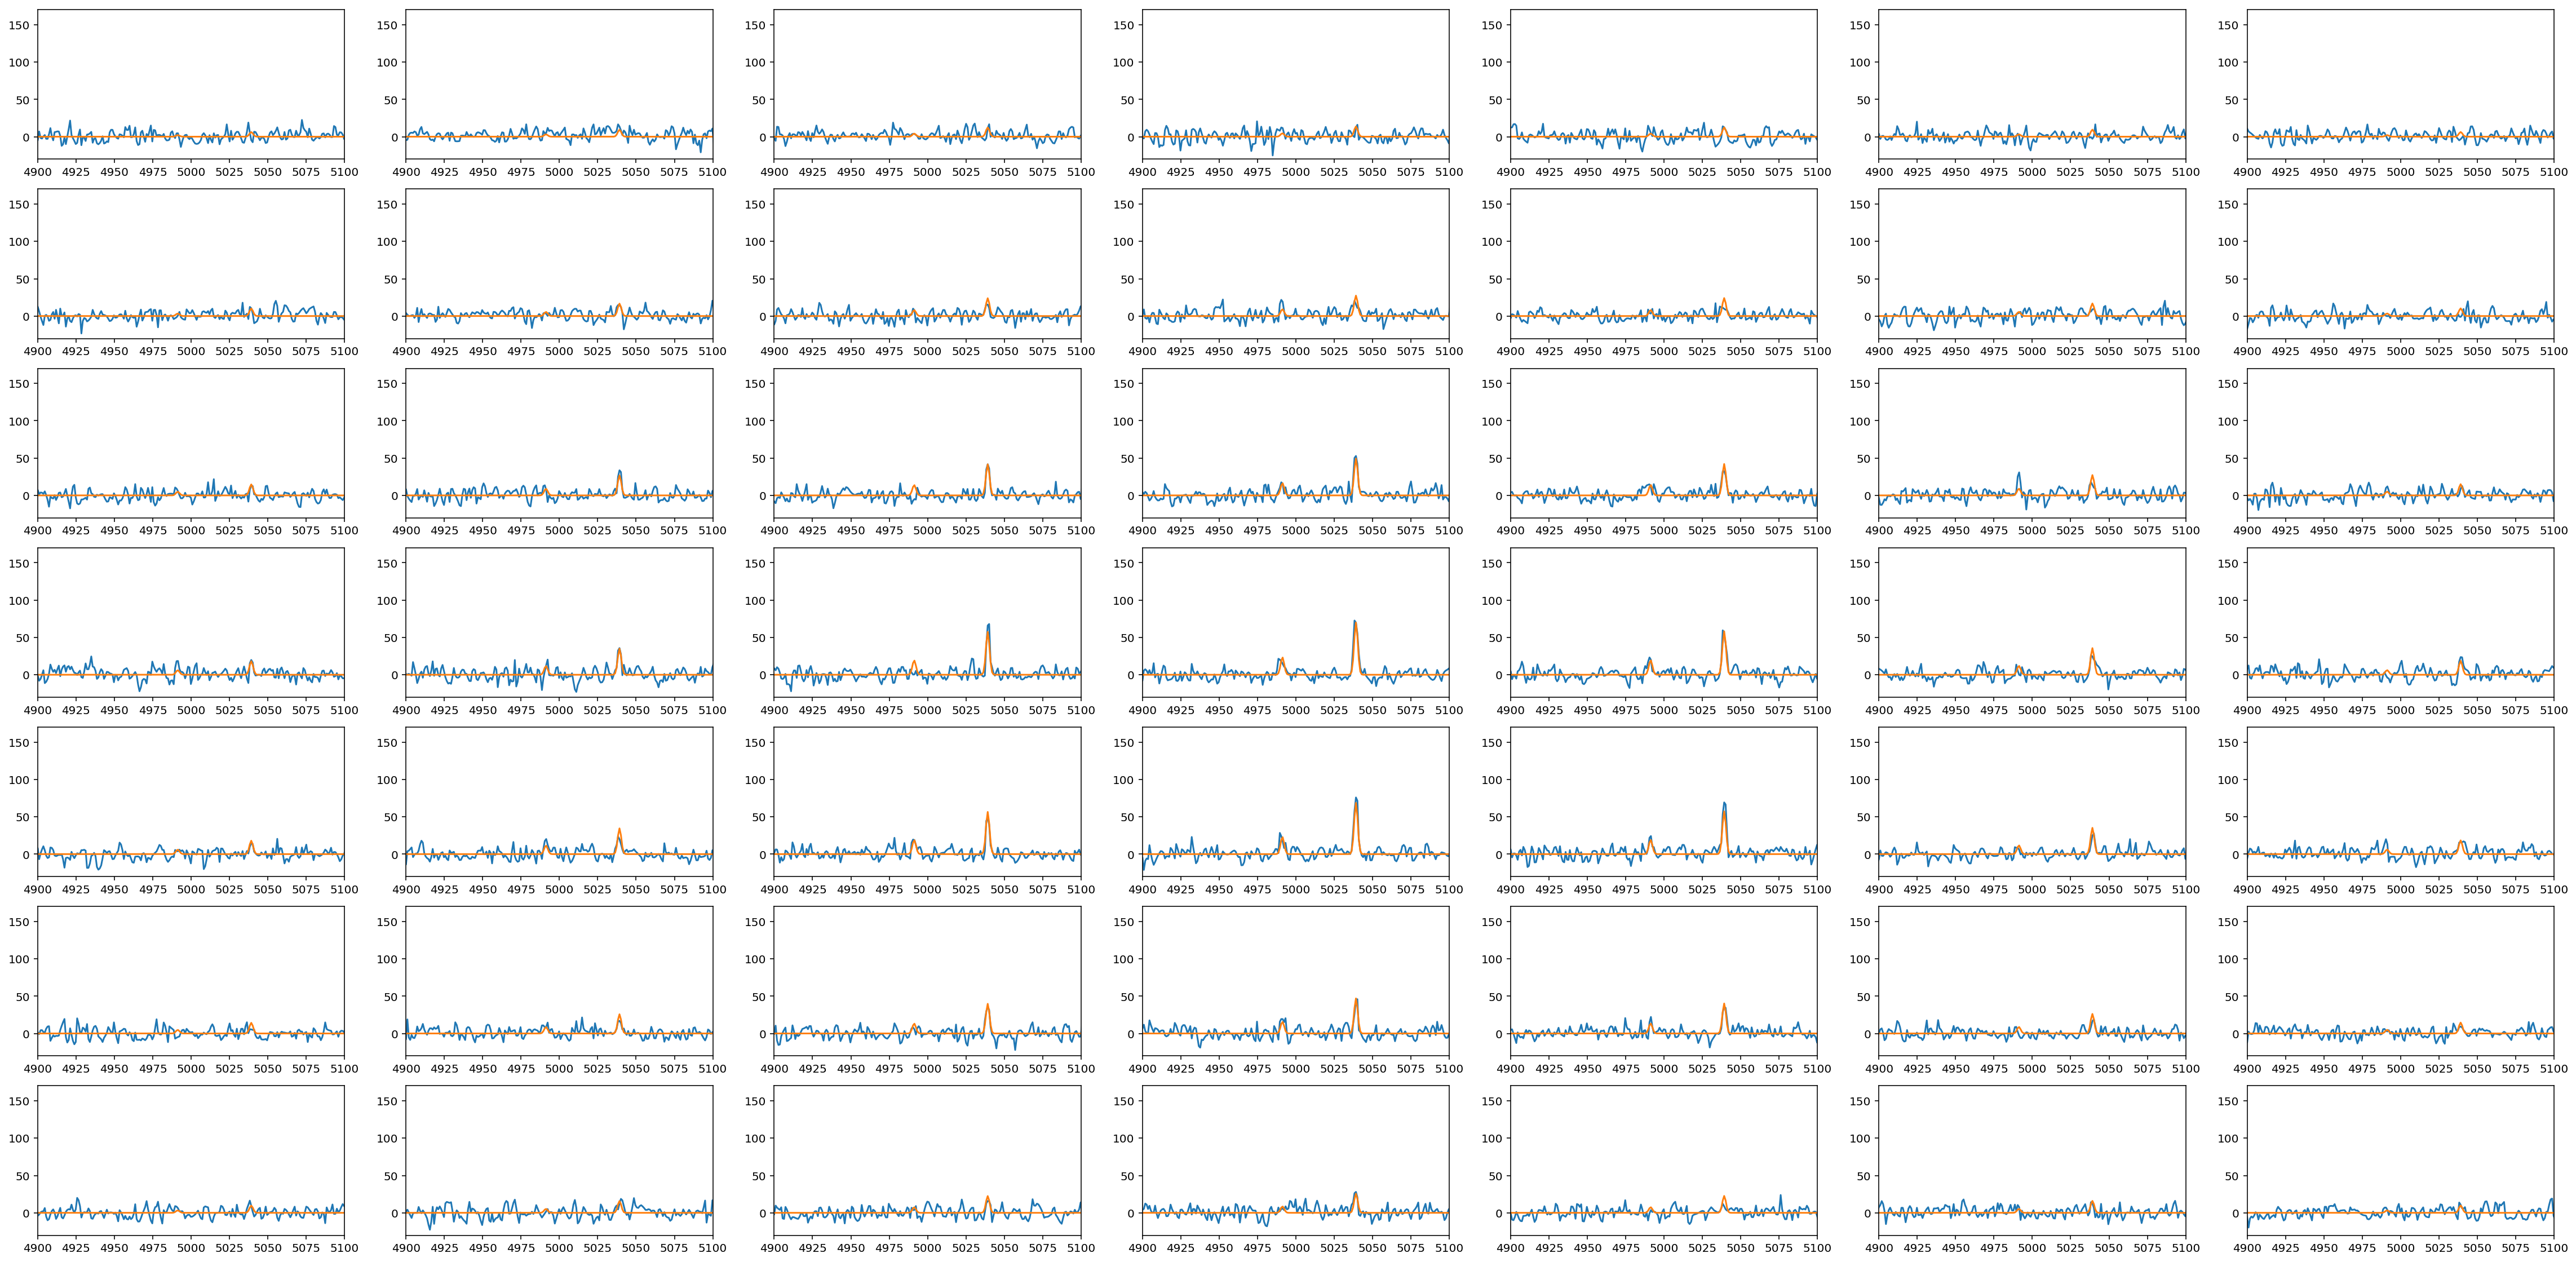

In [52]:
p = 23
PNe_n = PNe_spectra[p]
flux_1D = F_xy_list[p][0]
A_n = ((flux_1D) / (np.sqrt(2*np.pi) * 1.19))

def gaussian(x, amplitude, mean, stddev, bkg, grad):
    return (bkg + grad*x + np.abs(amplitude) * np.exp(- 0.5 * (x - mean)** 2 / (stddev**2.)) +
            (np.abs(amplitude)/3.) * np.exp(- 0.5 * (x - (mean - 47.9399))** 2 / (stddev**2.)))

list_of_gauss = [gaussian(wavelength, A, mean_wave_list[p][0], 1.19, Gauss_bkg[p], Gauss_grad[p]) for A in A_n]

plt.figure(figsize=(40,20))
for i, spec in enumerate(PNe_n):
    plt.subplot(n_pixels,n_pixels,i+1)
    plt.plot(wavelength, spec)
    plt.plot(wavelength, list_of_gauss[i])
    plt.xlim(4900,5100)
    plt.ylim(-30, 170)
    

#plt.savefig("Plots/FCC167/PNe_24 spectra grid.png")

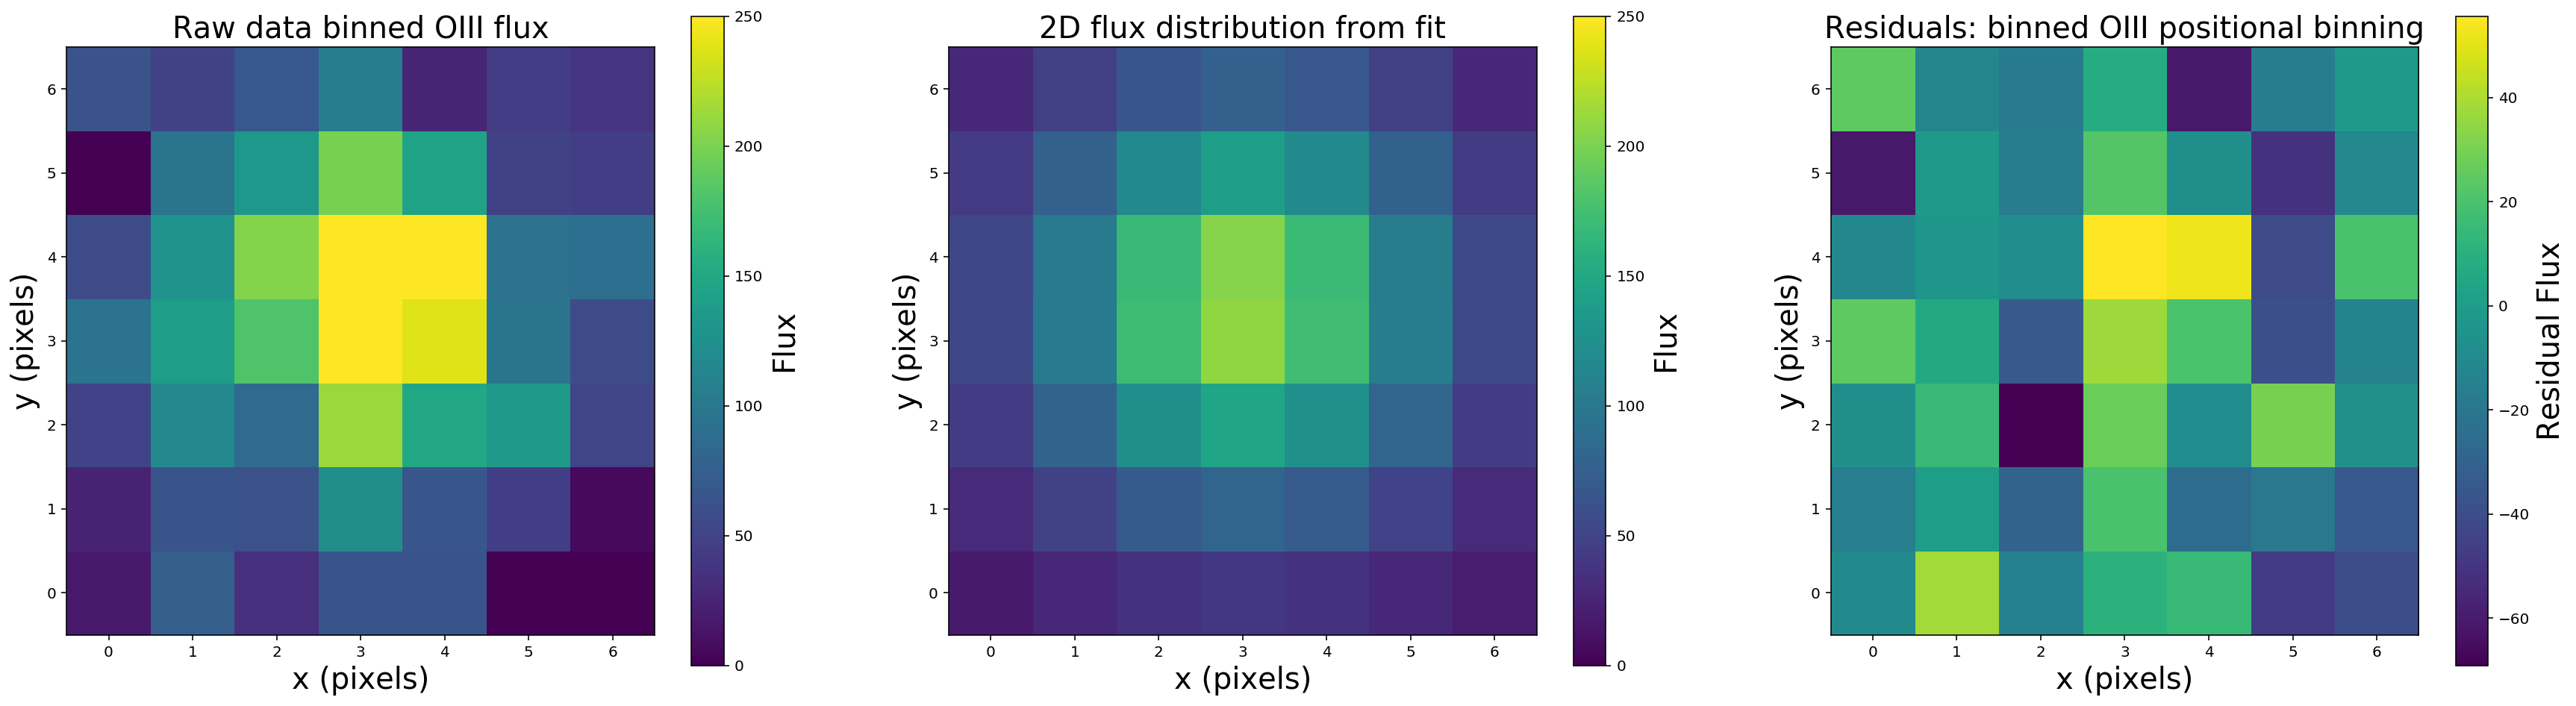

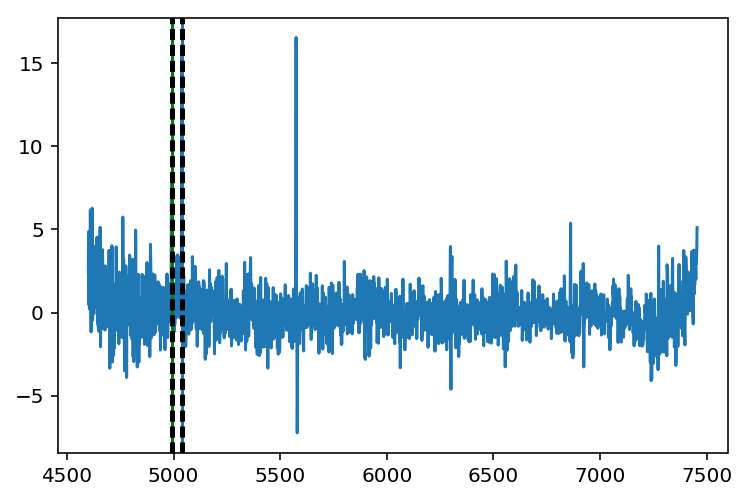

In [57]:
#(p, p+1)
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


for n in np.arange(p,p+1):#0, len(x_PNe)):
    PNe_n = PNe_spectra[n]
    sum_n = np.median(PNe_n,0)
    mean_n = mean_wave_list[n][0]
    peak_0 = find_nearest(wavelength, mean_n)#min(np.arange(len(wavelength)), key=lambda i: abs(wavelength[i]-mean_wave_list[n]))
    peak_1 = find_nearest(wavelength, mean_n-47.93)#min(np.arange(len(wavelength)), key=lambda i: abs(wavelength[i]-(mean_wave_list[n]-47.93)))
    #if (peak_1 is not peak_0 - 38) or (peak_1 is not peak_0 - 37):
    #    peak_1 = peak_0 - 38
    
    sum_peak_0 = np.sum(PNe_n[:,peak_0-2:peak_0+2],1)
    sum_peak_1 = np.sum(PNe_n[:,peak_1-2:peak_1+2],1)
    combined_peaks = sum_peak_0 + sum_peak_1
    combined_peaks_2D = combined_peaks.reshape(n_pixels, n_pixels)
    
    result_res = list_of_fit_residuals[n]
    result_res_list = result_res.reshape(n_pixels* n_pixels, len(wavelength))
    sum_peak_res_0 = np.sum(result_res_list[:,peak_0-2:peak_0+2],1)
    sum_peak_res_1 = np.sum(result_res_list[:,peak_1-2:peak_1+2],1)
    combined_peaks_res = sum_peak_res_0 + sum_peak_res_1
    combined_peaks_res_2D = combined_peaks_res.reshape(n_pixels, n_pixels)
    
    plt.figure(figsize=(30,8))
    plt.subplot(1,3,1)
    plt.imshow(combined_peaks_2D, origin="lower", vmin=0, vmax=250)
    plt.xlabel("x (pixels)", fontsize=20)
    plt.ylabel("y (pixels)", fontsize=20)
    plt.title("Raw data binned OIII flux", fontsize=20)
    cb = plt.colorbar(label="Flux")
    cb.set_label("Flux", fontsize=20)
    
    plt.subplot(1,3,2)
    plt.imshow(F_xy_list[n][0].reshape(n_pixels,n_pixels), origin="lower", vmin=0, vmax=250)
    plt.xlabel("x (pixels)", fontsize=20)
    plt.ylabel("y (pixels)", fontsize=20)
    plt.title("2D flux distribution from fit", fontsize=20)
    cb = plt.colorbar()
    cb.set_label("Flux", fontsize=20)
    
    plt.subplot(1,3,3)
    plt.imshow(combined_peaks_res_2D, origin="lower", vmin=np.min(combined_peaks_res_2D), vmax=np.max(combined_peaks_res_2D))
    plt.xlabel("x (pixels)", fontsize=20)
    plt.ylabel("y (pixels)", fontsize=20)
    plt.title("Residuals: binned OIII positional binning", fontsize=20)
    cb = plt.colorbar()
    cb.set_label("Residual Flux", fontsize=20)
    
    #plt.savefig("Plots/FCC167/data_model_residual_.png")
    
    plt.figure(7)
    plt.plot(wavelength, sum_n)
    plt.axvline(wavelength[peak_0])
    plt.axvline(wavelength[peak_0+4], ls="dashed", c="k")
    plt.axvline(wavelength[peak_0-4], ls="dashed", c="k")
    
    plt.axvline(wavelength[peak_1], c="green")
    plt.axvline(wavelength[peak_1+4], ls="dashed", c="k")
    plt.axvline(wavelength[peak_1-4], ls="dashed", c="k")


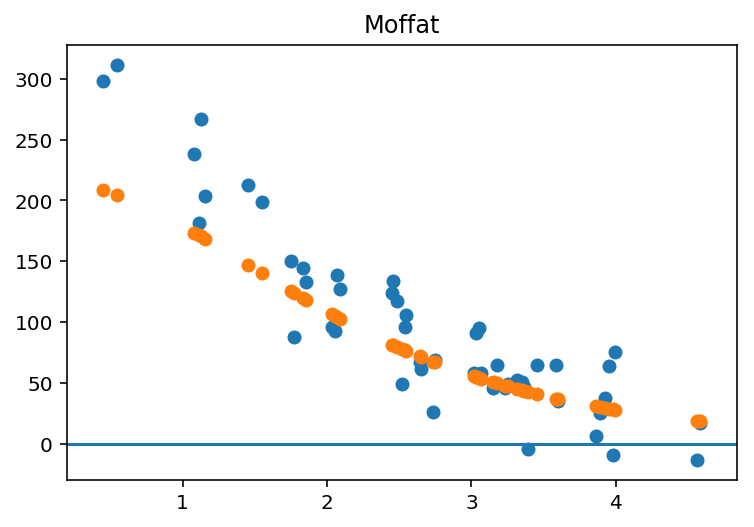

In [58]:
PNe_radials= np.sqrt((x_fit - list_of_x[p])**2 + (y_fit - list_of_y[p])**2)
plt.title("Moffat")
plt.scatter(PNe_radials, combined_peaks_2D)
plt.scatter(PNe_radials, F_xy_list[p][0])
#plt.axvline(r)
plt.axhline(0)

In [ ]:
# Residual
result_res = fit_results.residual
result_res_list = result_res.reshape(n_pixels* n_pixels, len(wavelength))
plt.figure(0,figsize=(40,20))
for i, spec in enumerate(result_res_list):
    plt.subplot(n_pixels,n_pixels,i+1)
    plt.plot(wavelength, spec)
    plt.plot(wavelength, list_of_gauss[i])
    plt.ylim(-20,140)

sum_n_res = np.sum(result_res_list,0)
plt.figure(1)
plt.plot(wavelength, sum_n_res)
plt.axvline(wavelength[peak_0])
plt.axvline(wavelength[peak_0+2], ls="dashed", c="k")
plt.axvline(wavelength[peak_0-2], ls="dashed", c="k")

plt.axvline(wavelength[peak_1], c="green")
plt.axvline(wavelength[peak_1+2], ls="dashed", c="k")
plt.axvline(wavelength[peak_1-2], ls="dashed", c="k")

mean_n = mean_wave_list[n]
sum_peak_0 = np.sum(result_res_list[:,peak_0-4:peak_0+4],1)
sum_peak_1 = np.sum(result_res_list[:,peak_1-4:peak_1+4],1)
combined_peaks = sum_peak_0 + sum_peak_1
plt.figure(2)
plt.imshow(combined_peaks.reshape(n_pixels, n_pixels), origin="lower", vmin=-np.max(combined_peaks), vmax=np.max(combined_peaks))
plt.colorbar()

# Completeness

In [54]:
Noise_map = np.abs(np.std(raw_data_cube, axis=2))

# mask out regions where sep masks
Y, X = np.mgrid[:y_data, :x_data]
xe = 236
ye = 197
length= 140
wide = 60
alpha = 0.2
elip_mask_gal = (((X-xe) * np.cos(alpha) + (Y-ye) * np.sin(alpha)) / (wide/2)) ** 2 + (((X-xe) * np.sin(alpha) - (Y-ye) * np.cos(alpha)) / (length/2)) ** 2 <= 1

Noise_map[elip_mask_gal == True] = 0.0

#plt.imshow(Noise_map, origin="lower", cmap="CMRmap", vmin=0, vmax=20)

# Setup range of Absolute Magnitudes to be converted to 1D max A values
#Abs_M = bins_cens # np.arange(-4.5,-1.5, 0.5)#bins_cens
#dM = 5. * np.log10(18.7)+25
app_m = bins_cens

total_flux = 10**((app_m + 13.74) / -2.5)
flux = total_flux / 1e-20

def moffat(amplitude, x_0, y_0, FWHM, beta):
    gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
    rr_gg = ((x_fit - x_0)**2 + (y_fit - y_0)**2) / gamma**2
    return amplitude * (1 + rr_gg)**(-beta)

def gaussian(x, amplitude, mean, stddev, bkg, grad):
    return (bkg + grad*x + np.abs(amplitude) * np.exp(- 0.5 * (x - mean)** 2 / (stddev**2.)) +
                 (np.abs(amplitude)/3.) * np.exp(- 0.5 * (x - (mean - 47.9399))** 2 / (stddev**2.)))

init_FWHM = PNe_params["M_FWHM"].value
init_beta = PNe_params["beta"].value
sum_init = np.sum(moffat(1, n_pixels/2, n_pixels/2, init_FWHM, init_beta))
input_moff_A = flux / sum_init

# Make moffat models = F_5007 (x,y)
Moffat_models = np.array([moffat(moff_A, n_pixels/2., n_pixels/2., init_FWHM, init_beta) for moff_A in input_moff_A])

# A_5007 (x,y)
Amp_x_y = ((Moffat_models) / (np.sqrt(2*np.pi) * 1.19))

max_1D_A = np.array([np.max(A) for A in Amp_x_y])

N_data = len(np.nonzero(Noise_map)[0])

Noise_mask = Noise_map
Noise_mask_plot = []
ratio_counter = np.zeros(len(app_m))
for i,a in enumerate(max_1D_A):
    Noise_mask[((a / Noise_map) <2.0)] = np.nan
    nan_counter = np.isnan(Noise_mask).sum()

    ratio_counter[i] = (N_data-nan_counter) / N_data
    Noise_mask_plot.append(Noise_mask)
#    plt.figure(figsize=(14,14))
#    plt.title("Absolute Magniude %s" %Abs_M[i])
#    plt.imshow(Noise_mask, origin="lower", vmin=0, vmax=20)
#    cb=plt.colorbar()
#    plt.savefig("Plots/FCC167/completeness/Abs M %s.png" %Abs_M[i])
#
#Noise_mask = Noise_map
#Noise_mask_plot = []
#
#fig, axs = plt.subplots(2,3, figsize=(20, 10))
#axs = axs.ravel()
#for i,a in enumerate(max_1D_A):
#    Noise_mask[((a / Noise_map) <2.0)] = np.nan
#    axs[i].set_title("$M_{5007} = $ %s" %Abs_M[i])
#    ax = axs[i].imshow(Noise_mask, origin="lower", vmin=0, vmax=30)
#
#plt.savefig("Plots/FCC167/completeness/stack.png")



C:\Users\tspri\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\tspri\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in less


## PNLF Fitting Routine

In [62]:
PNLF_df = pd.DataFrame(columns=("m 5007", "PNLF", "binned_values"))
PNLF_df["m 5007"] = PNe_df["m 5007"].loc[PNe_df["A/rN"]>2.0]

diff = abs(bins_cens[0]-bins_cens[1]) / 2
bins_cens_left = bins_cens - diff
bins_cens_right = bins_cens + diff

PNLF_df["binned_values"] = np.digitize(PNLF_df["m 5007"], bins=bins_cens)

def PNLF_func(params, data):
    c1 = params["c1"]
    c2 = params["c2"]
    
    # PNLF equation
    PNLF = c1*np.exp(c2*PNLF_df["m 5007"]) * (1-np.exp(3*((PNLF_df["m 5007"].min() - PNLF_df["m 5007"]))))
    PNLF_df["PNLF"] = PNLF
    # Binning of PNLF values
    PNLF_sum_list = np.zeros(len(bins_cens))
    for i in np.arange(1,len(bins_cens)+1):
        PNLF_sum_list[i-1] = np.mean(PNLF_df["PNLF"].loc[PNLF_df["binned_values"]==i])
    # Scale the binned values

    return data - PNLF_sum_list
                
params_PNLF = Parameters()
params_PNLF.add("c1", value=1., vary=True)
params_PNLF.add("c2", value=0.307, vary=False)

results = minimize(PNLF_func, params_PNLF, args=(bins,), nan_policy="propagate")
#plt.hist(PNe_df["M 5007"].loc[PNe_df["A/rN"]>2], edgecolor="black", linewidth=0.8, label="M 5007 >2 * A/rN", alpha=0.5)
report_fit(results)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 5
    # data points      = 13
    # variables        = 1
    chi-square         = 184.515464
    reduced chi-square = 15.3762887
    Akaike info crit   = 36.4861910
    Bayesian info crit = 37.0511403
[[Variables]]
    c1:  0.00127841 +/- 2.6739e-04 (20.92%) (init = 1)
    c2:  0.307 (fixed)


[0.63746619 2.03232702 2.93165835 3.79601671 4.30925816 4.80302028
 5.3287928  5.61648495 6.05034599 6.26027952 6.68124797 6.98233359
 7.29204807]


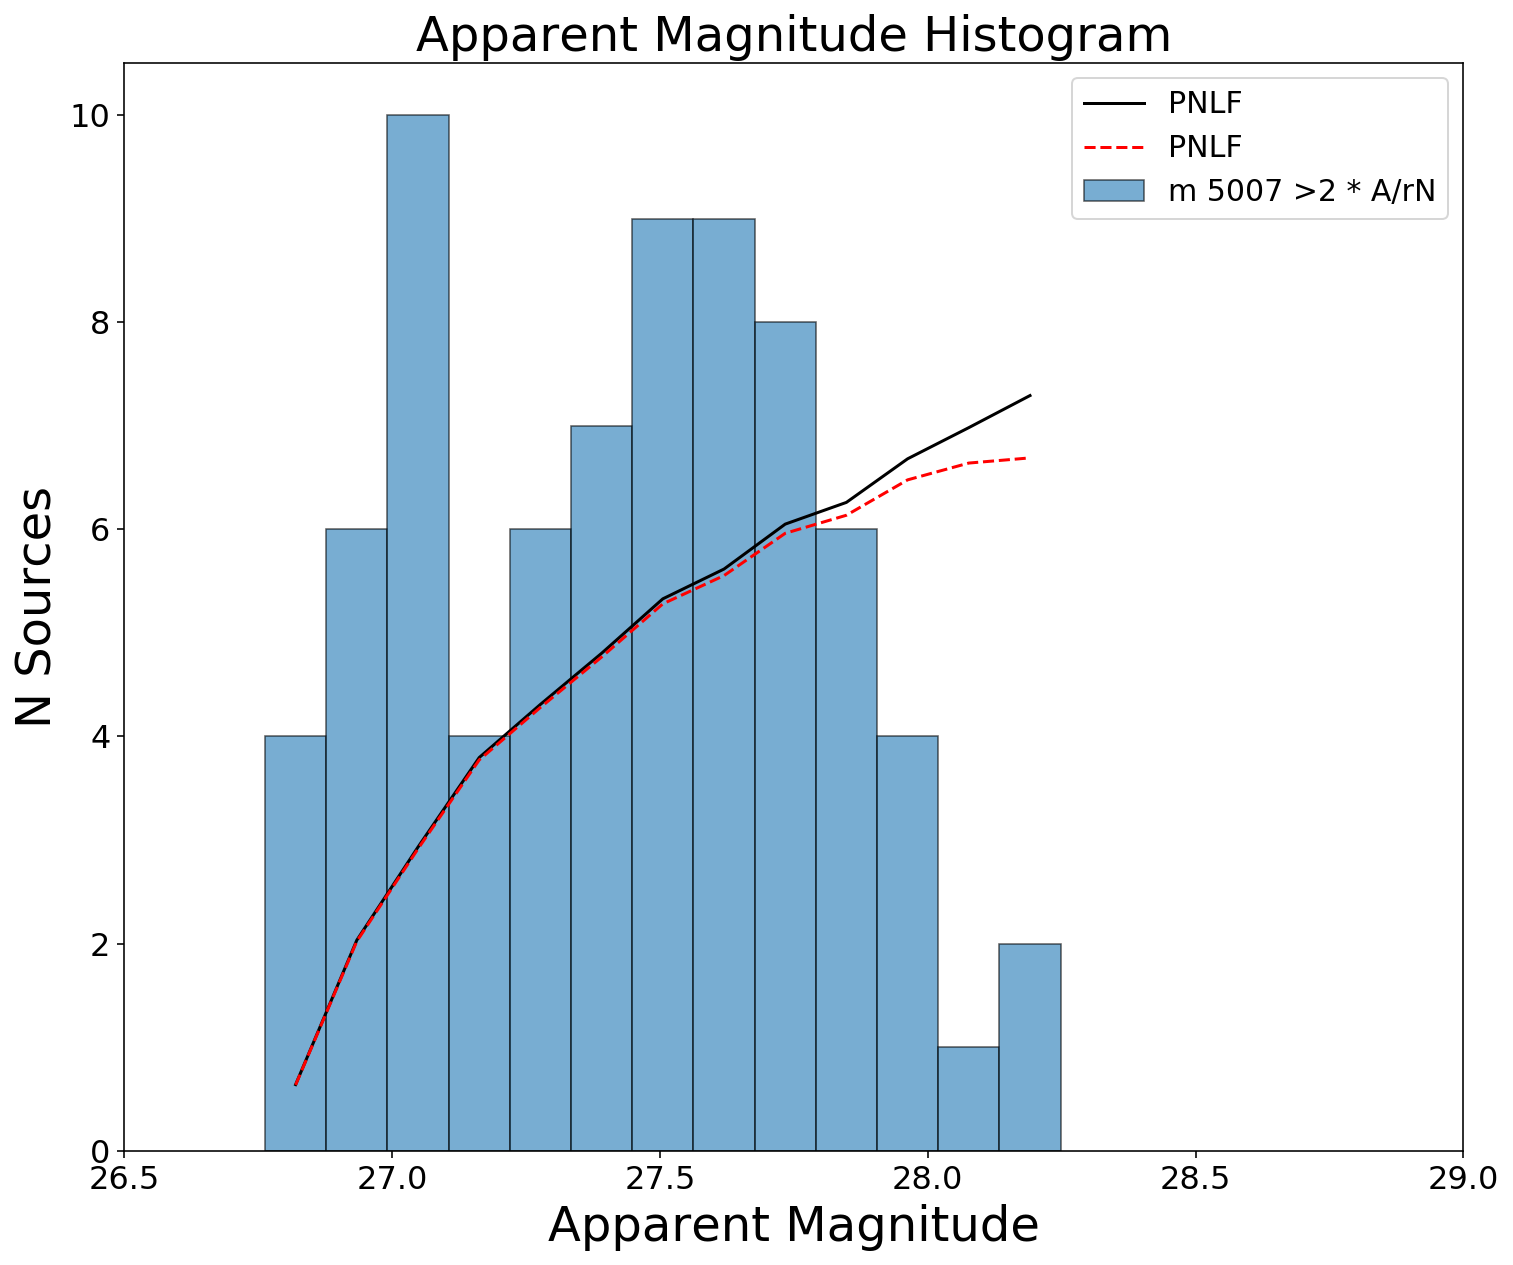

In [63]:
plt.figure(2, figsize=(12,10))
info = plt.hist(PNe_df["m 5007"].loc[PNe_df["A/rN"]>2], bins=len(bins), edgecolor="black", linewidth=0.8, label="m 5007 >2 * A/rN", alpha=0.6)
ax = plt.gca()
plt.xlim(26.5,29.0)
#plt.yticks(np.arange(0,22,2), np.arange(0,22,2))
plt.title("Apparent Magnitude Histogram", fontsize=24)
plt.xlabel("Apparent Magnitude", fontsize=24)
plt.ylabel("N Sources", fontsize=24)
ax.get_yticklabels()
ax.tick_params(labelsize=18)
ax.tick_params(labelsize=16)
#plt.savefig("Plots/FCC167/M5007 histogram.png")

PNLF = results.params["c1"].value*(np.exp(np.abs(results.params["c2"].value)*PNe_df["m 5007"])) * (1-np.exp(3*((PNe_df["m 5007"].min() - PNe_df["m 5007"]))))
#PNLF = (PNLF * results.params["a"]) 
#plt.scatter(PNe_df["M 5007"].loc[PNe_df["M 5007"]>-5], PNLF, c="k")


binned_PNLF = np.zeros(len(bins_cens))
for i in np.arange(1,len(bins_cens)+1):
    binned_PNLF[i-1] = np.mean(PNLF_df["PNLF"].loc[PNLF_df["binned_values"]==i])
    
print(binned_PNLF)
plt.plot(bins_cens_right, (binned_PNLF), color="k", label="PNLF" )
plt.plot(bins_cens_right, (binned_PNLF) * ratio_counter, color="r", ls="--", label="PNLF" )
plt.legend(fontsize=15)
plt.savefig("Plots/FCC167/PNLF.png")

## Error estimation

In [19]:
def MUSE_3D_err(params, l, x_2D, y_2D, data):
    moffat_amp = params['A_err']
    x_0 = params['x_err']
    y_0 = params['y_err']
    FWHM = params['FWHM_err']
    beta = params["beta_err"]
    mean = params["mean_err"]
    Gauss_FWHM = params["Gauss_FWHM_err"]
    Gauss_bkg = params["Gauss_bkg_err"]
    Gauss_grad = params["Gauss_grad_err"]
    
    #Moffat model
    gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
    rr_gg = ((np.array(x_2D) - x_0)**2 + (np.array(y_2D) - y_0)**2) / gamma**2
    F_OIII_xy = moffat_amp * (1 + rr_gg)**(-beta)
    
    comb_FWHM = np.sqrt(2.81**2 + Gauss_FWHM**2)
    Gauss_std = comb_FWHM / 2.35482
    
    # Convert Moffat flux to amplitude
    A_OIII_xy = ((F_OIII_xy) / (np.sqrt(2*np.pi) * Gauss_std))
    
    #Construct model gaussian profiles for each amplitude value in cube
    model_spectra = [(Gauss_bkg + (Gauss_grad * l) + np.abs(Amp) * np.exp(- 0.5 * (l - mean)** 2 / Gauss_std**2.) +
             (np.abs(Amp)/3.0) * np.exp(- 0.5 * (l - (mean - 47.9399))** 2 / Gauss_std**2.)) for Amp in A_OIII_xy]
    
    return np.sum(F_OIII_xy * 1e-20)

high_F_list = np.zeros(len(x_PNe))
low_F_list = np.zeros(len(x_PNe))

for num in np.arange(0, len(x_PNe)):
    error_params_add = Parameters()
    error_params_add.add("A_err", value=M_amp_list[num] + moff_A_err[num], vary=False)
    error_params_add.add("x_err", value=list_of_x[num] + x_0_err[num], vary=False)
    error_params_add.add("y_err", value=list_of_y[num] + y_0_err[num], vary=False)
    error_params_add.add("FWHM_err", value=PNe_params["FWHM"].value + FWHM_in_err, vary=False)
    error_params_add.add("beta_err", value=PNe_params["beta"].value + beta_in_err, vary=False)
    error_params_add.add("mean_err", value=mean_wave_list[num] + mean_wave_err[num], vary=False)
    error_params_add.add("Gauss_FWHM_err", value=PNe_params["Gauss_FWHM"].value + 0.0, vary=False)
    error_params_add.add("Gauss_bkg_err", value=Gauss_bkg[num] + Gauss_bkg_err[num], vary=False)
    error_params_add.add("Gauss_grad_err", value=Gauss_grad[num] + Gauss_grad_err[num], vary=False)
    
    error_params_minus = Parameters()
    error_params_minus.add("A_err", value=M_amp_list[num] - moff_A_err[num], vary=False)
    error_params_minus.add("x_err", value=list_of_x[num] - x_0_err[num], vary=False)
    error_params_minus.add("y_err", value=list_of_y[num] - y_0_err[num], vary=False)
    error_params_minus.add("FWHM_err", value=PNe_params["FWHM"].value - FWHM_in_err, vary=False)
    error_params_minus.add("beta_err", value=PNe_params["beta"].value - beta_in_err, vary=False)
    error_params_minus.add("mean_err", value=mean_wave_list[num] - mean_wave_err[num], vary=False)
    error_params_minus.add("Gauss_FWHM_err", value=PNe_params["Gauss_FWHM"].value - 0.0, vary=False)
    error_params_minus.add("Gauss_bkg_err", value=Gauss_bkg[num] - Gauss_bkg_err[num], vary=False)
    error_params_minus.add("Gauss_grad_err", value=Gauss_grad[num] - Gauss_grad_err[num], vary=False)
    
    model_add = MUSE_3D_err(error_params_add, wavelength, x_fit, y_fit, PNe_spectra[num])
    high_F_list[num] = model_add
    model_minus = MUSE_3D_err(error_params_minus, wavelength, x_fit, y_fit, PNe_spectra[num])
    low_F_list[num] = model_minus

delta_F_high = high_F_list - PNe_df["Total Flux"]
delta_F_low = PNe_df["Total Flux"] - low_F_list

PNe_df["Flux error"] = np.median((delta_F_high, delta_F_low))

PNe_df["M 5007 error"] = 1.09 * (PNe_df["Flux error"] / PNe_df["Total Flux"])

# Load in saved data

In [59]:
# Pull out the 1D flux data from 1D fits to do radial comparison
gauss_1D_A = np.load("exported_data/FCC167/gauss_A_cen.npy")
A_rN_plot = np.load("exported_data/FCC167/A_rN_cen.npy")

gauss_A_shape = gauss_1D_A.reshape(y_data, x_data)
rN = np.load("exported_data/FCC167/rN.npy")
rN_shape = rN.reshape(y_data,x_data)
#rN_shape[np.isnan(rN_shape)] = 0

Flux_1D = gauss_1D_A * np.sqrt(2*np.pi) * 1.19
Flux_1D_cube = Flux_1D.reshape(y_data, x_data)
A_rN_plot_shape = A_rN_plot.reshape(y_data, x_data)

PNe_1D_flux_data = np.array([PNextractor(x, y, n_pixels, Flux_1D_cube, dim=1.0) for x,y in zip(x_PNe,y_PNe)])
PNe_1D_A_rN_data = np.array([PNextractor(x, y, n_pixels, A_rN_plot_shape, dim=1.0) for x,y in zip(x_PNe,y_PNe)])

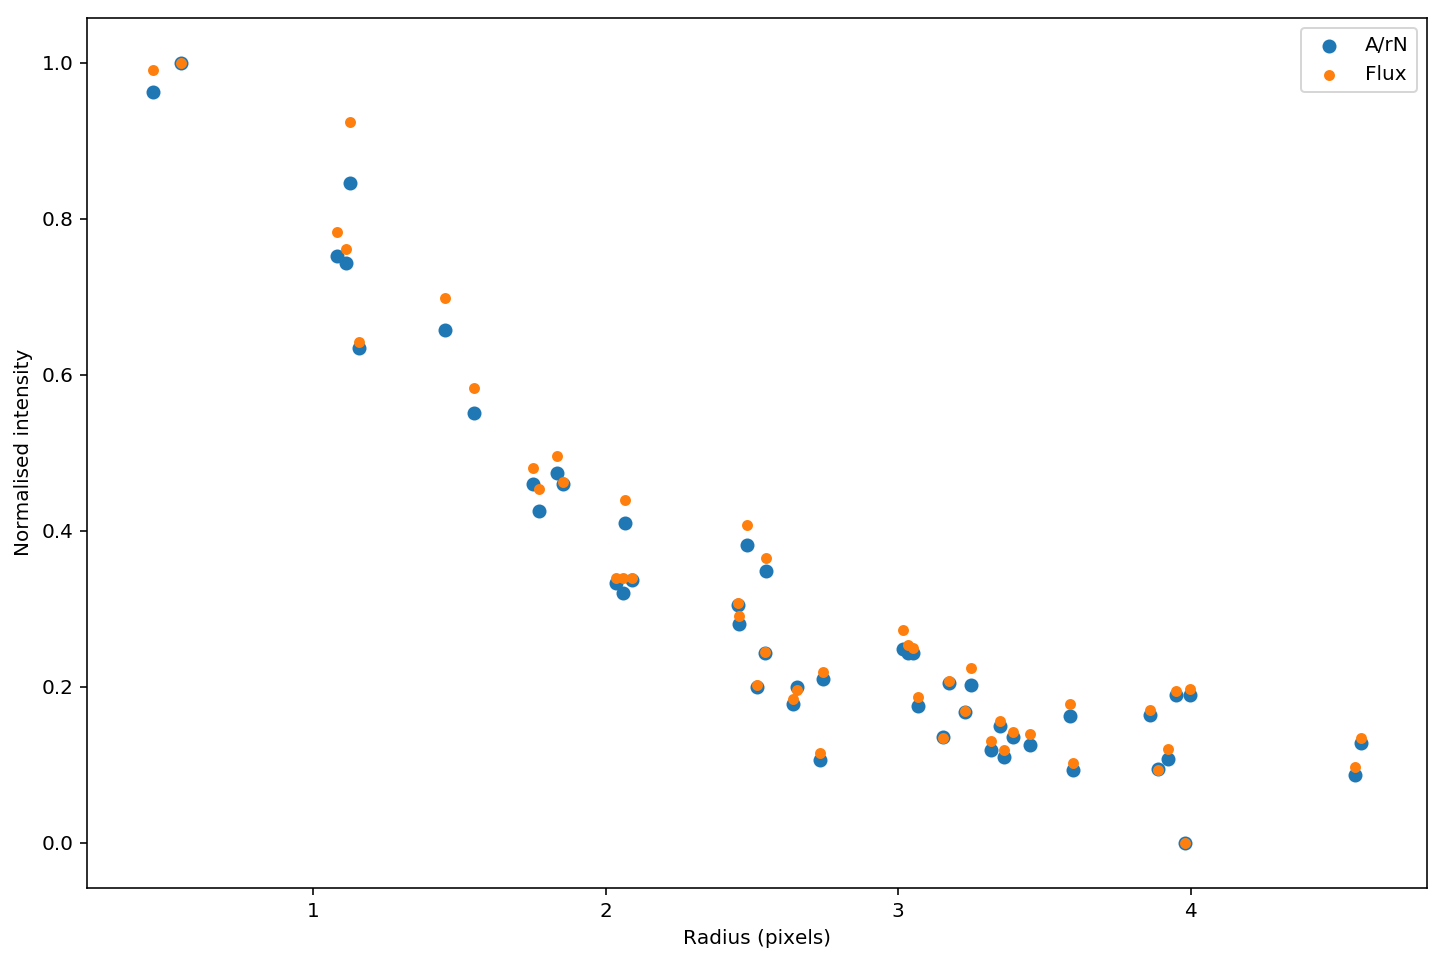

In [95]:
k = 23
plt.figure(figsize=(12,8))
PNe_radials= np.sqrt((x_fit - list_of_x[k])**2 + (y_fit - list_of_y[k])**2)
plt.scatter(PNe_radials, PNe_1D_A_rN_data[k]/np.max(PNe_1D_A_rN_data[k]), label="A/rN")
#plt.figure()
plt.scatter(PNe_radials, PNe_1D_flux_data[k]/np.max(PNe_1D_flux_data[k]), s=20, label="Flux")
#plt.axvline(r)
plt.legend()
plt.xlabel("Radius (pixels)")
plt.ylabel("Normalised intensity")
plt.savefig("Plots/FCC167/normalised_comp_ArN_F_OIII.png")

## Flux and A/rN maps, with circled sources

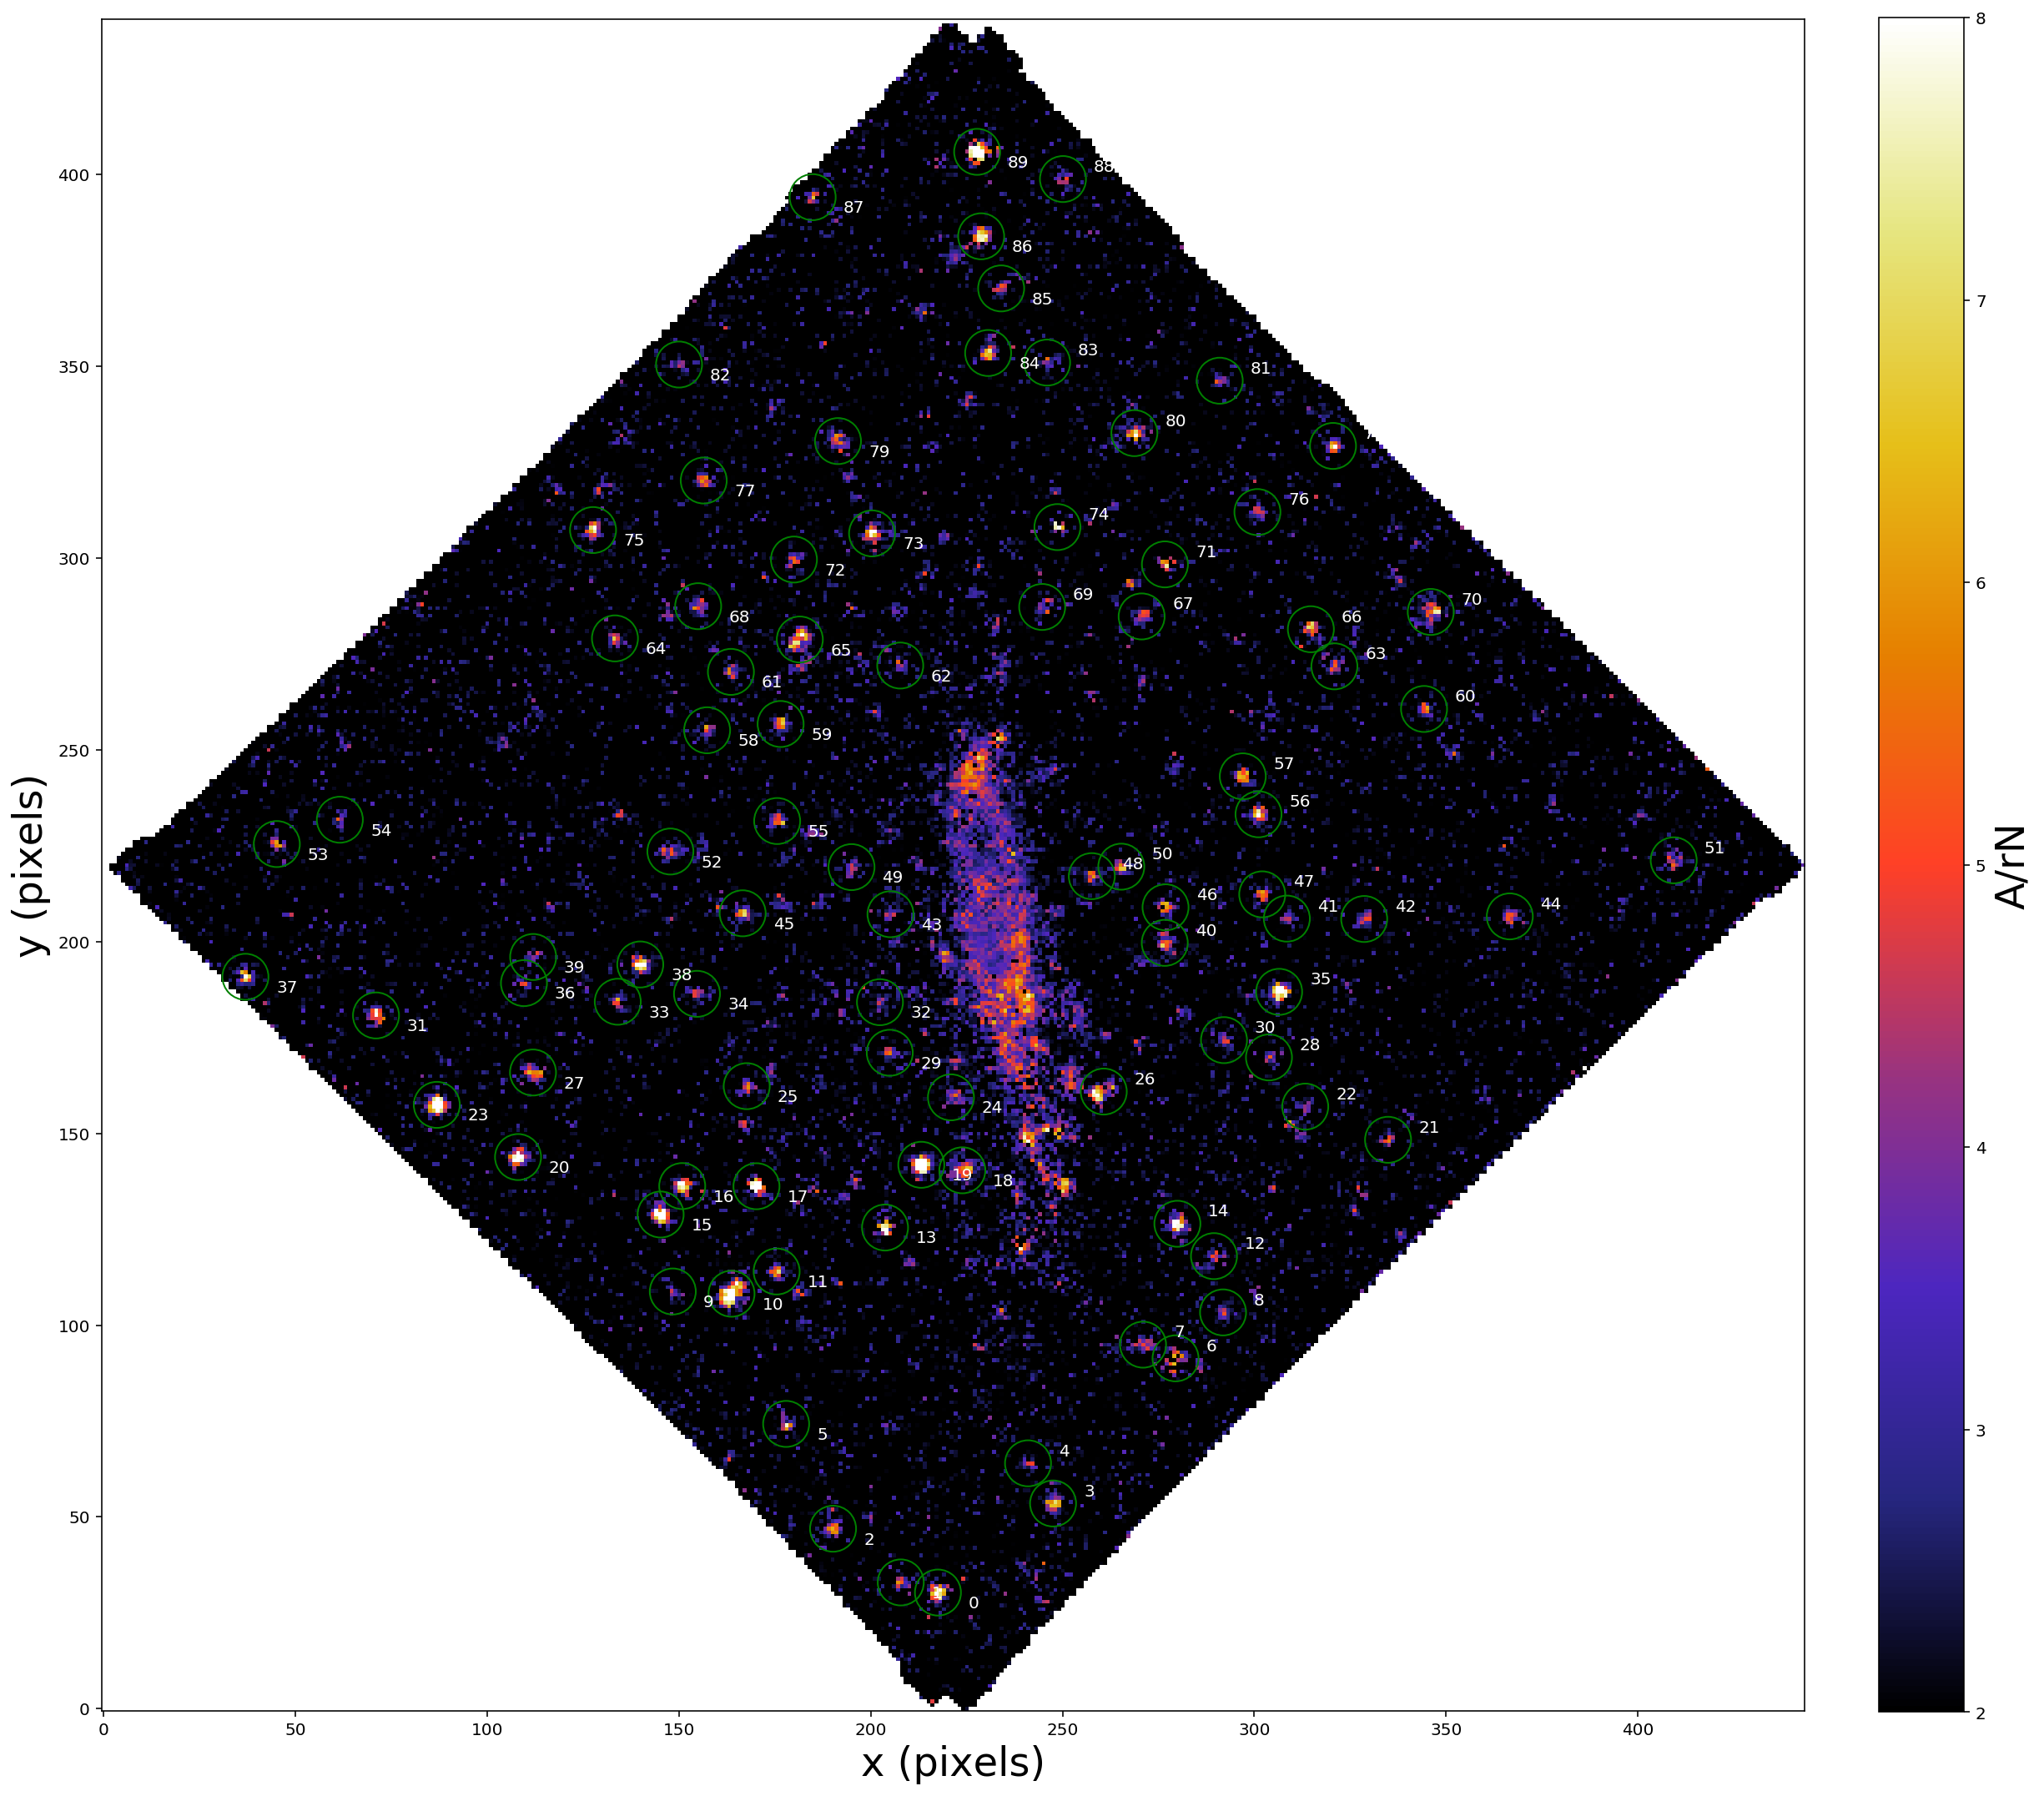

In [19]:
plt.figure(figsize=(20,20))
plt.imshow(A_rN_plot_shape, origin="lower", cmap="CMRmap", vmin=2, vmax=8)
ax = plt.gca()
cb=plt.colorbar(fraction=0.0455, pad=0.04)
cb.set_label("A/rN",fontsize=24)
#cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=20)
plt.xlabel("x (pixels)", fontsize=24)
plt.ylabel("y (pixels)", fontsize=24)
#circ_r = plt.Circle((x_data/2.,y_data/2.), 80, color="white", fill=False)
#ax.add_artist(circ_r)
for i, item in enumerate(x_y_list):
    ax = plt.gca()
    circ = plt.Circle((item[0],item[1]),6, color="green", fill=False)
    ax.add_artist(circ)
    if item[0]<240.:
        ax.annotate(i, (item[0]+8, item[1]-4), color="white", size=10)
    else:
        ax.annotate(i, (item[0]+8, item[1]+2), color="white", size=10)

#plt.savefig("Plots/FCC167/Flux_map.png")
#plt.savefig("Plots/FCC167/ArN_map.png")
plt.savefig("Plots/FCC167/ArN_circled_circled_PNe.png")

90


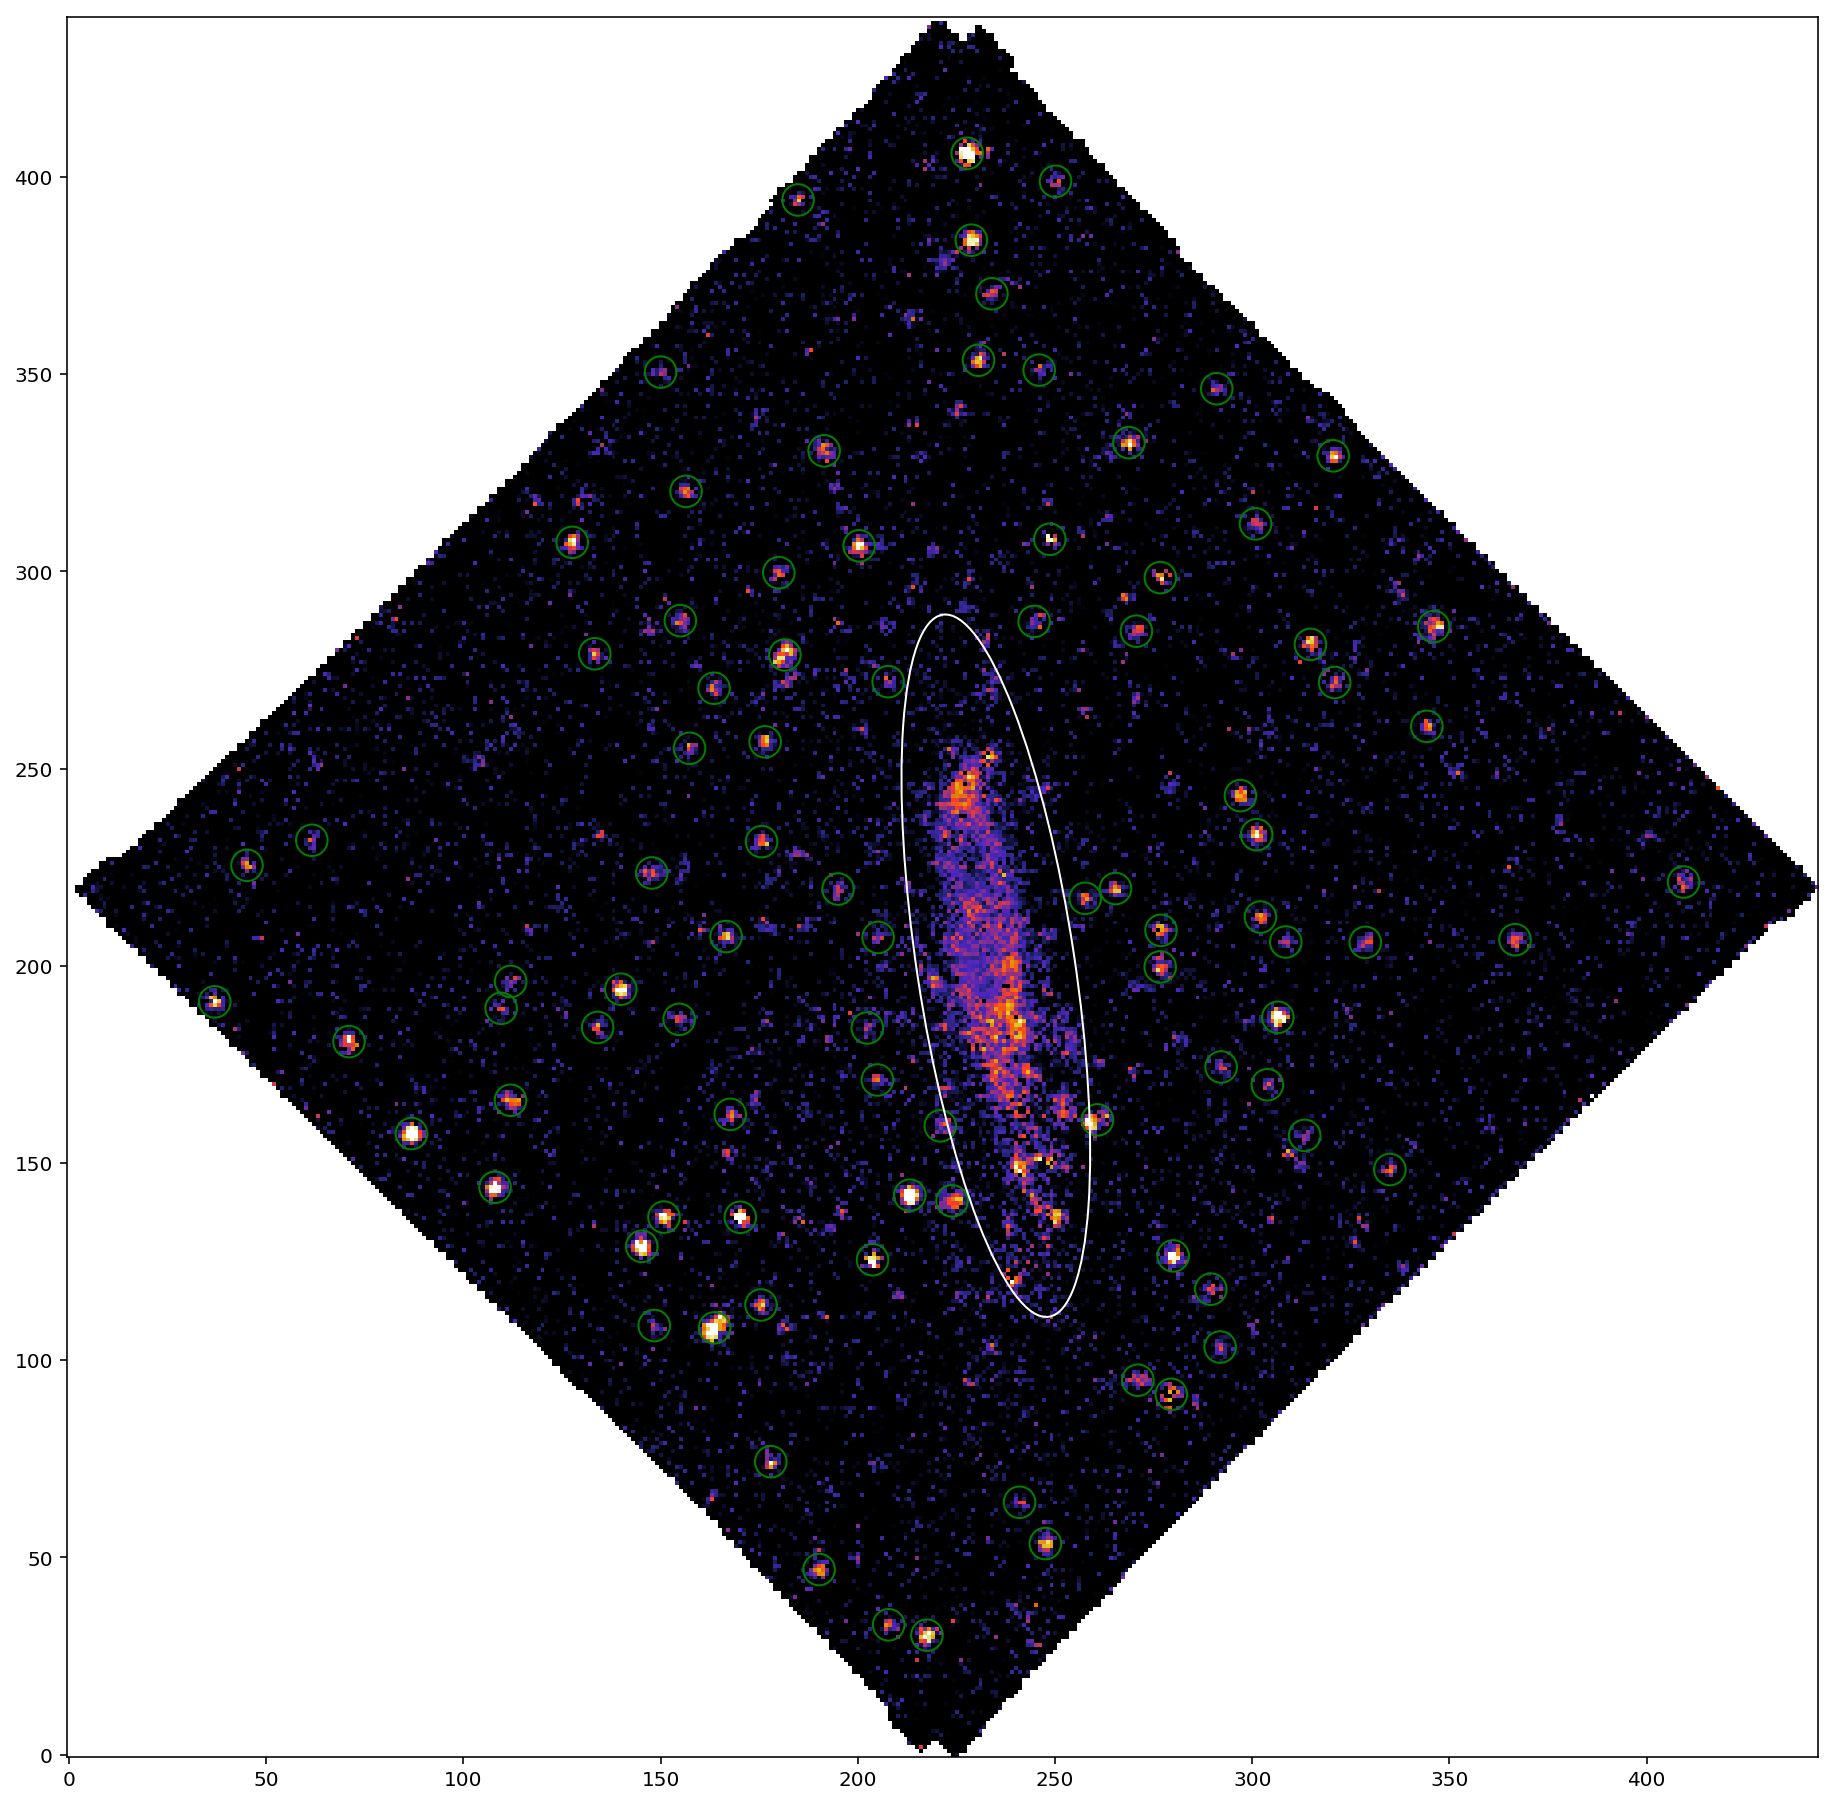

In [137]:
import sep
from photutils import CircularAperture

A_rN_plot_shape[A_rN_plot_shape == A_rN_plot_shape[0,0]] = 0.0

Y, X = np.mgrid[:y_data, :x_data]
xe = 235
ye = 200
length= 180
width = 40

alpha = 0.15
elip_mask_gal = (((X-xe) * np.cos(alpha) + (Y-ye) * np.sin(alpha)) / (width/2)) ** 2 + (((X-xe) * np.sin(alpha) - (Y-ye) * np.cos(alpha)) / (length/2)) ** 2 <= 1
PNe_17_mask = (X-213)**2 + (Y-142)**2 <=4**2
#galaxy_elip_mask = np.load("exported_data/FCC167/mask.npy")
#objects = sep.extract(gauss_A.reshape(441, 444), 7., err=list_of_std.reshape(y_data, x_data), clean=False, mask=elip_mask)
objects = sep.extract(A_rN_plot_shape, 2.8, clean=True, mask=elip_mask_gal)#, err=rN_shape)#+PNe_17_mask)
x_sep = objects["x"]
y_sep = objects["y"]

positions = (x_sep, y_sep)
apertures = CircularAperture(positions, r=4)
plt.figure(figsize=(16,16))
plt.imshow(A_rN_plot_shape, origin="lower", cmap="CMRmap", vmin=2, vmax=8.)
apertures.plot(color="green")

ax = plt.gca()
elip_gal = Ellipse((xe, ye), width, length, angle=alpha*(180/np.pi), fill=False, color="white")
PNe_17 = Circle((213,142), fill=False, color="white")
#elip_extra = Ellipse((210,230), 20, 50, angle=alpha*(180/np.pi), fill=False, color="white")

ax.add_artist(elip_gal)
#ax.add_artist(PNe_17)

#ax.add_artist(circ)


sep_x_y_list = [[x,y] for x,y in zip(x_sep, y_sep)]

print(len(x_sep))

np.save("exported_data/FCC167/PNe_x_y_list", sep_x_y_list)

# Velocity vs M_{5007}

In [ ]:
#%% Work on stellar dispersion comparison plot
stellar_vel = 0. # km/s
stellar_dis = 240. # km/s
PNe_vel_ratio = (PNe_df["V (km/s)"].loc[PNe_df["A/rN"]>3.] - stellar_vel)/ stellar_dis

plt.figure(44, figsize=(12,10))
plt.clf()
plt.scatter(PNe_df["M 5007"].loc[PNe_df["A/rN"]>3.], PNe_vel_ratio, s=100)
plt.xlabel("$M_{5007}$", fontsize=20)
plt.ylabel("$V_{PNe} - V_{*} / \sigma_*$", fontsize=20)
plt.axhline(y=1, c="k", ls="dashed")
plt.axhline(y=0, c="k", ls="dashed")
plt.axhline(y=-1, c="k", ls="dashed")
plt.ylim(-2,2)
plt.xlim(-5,0)

# PSF Fitter - Simultaneous object fitter

In [17]:
# Single Run PSF Fitter
sel_PNe = PNe_df.nsmallest(5, "m 5007").index.values
#sel_PNe = [10]
print(sel_PNe)

selected_PNe = PNe_spectra[sel_PNe]
selected_PNe_err = np.ones_like(selected_PNe)
PSF_params = Parameters()

def model_params(p, n, amp, mean):
    PSF_params.add("moffat_amp_{:03d}".format(n), value=amp, min=0.001)
    PSF_params.add("x_{:03d}".format(n), value=n_pixels/2., min=0.001, max=n_pixels)
    PSF_params.add("y_{:03d}".format(n), value=n_pixels/2., min=0.001, max=n_pixels)
    PSF_params.add("wave_{:03d}".format(n), value=mean, min=5000., max=5070.)
    PSF_params.add("gauss_bkg_{:03d}".format(n), value=0.0001 )
    PSF_params.add("gauss_grad_{:03d}".format(n), value=0.0001)


for i in np.arange(0,len(sel_PNe)):
        model_params(p=PSF_params, n=i, amp=200.0, mean=5007*(1+z))    
    
PSF_params.add('FWHM', value=4.0, min=0.01, max=12., vary=True)
PSF_params.add("beta", value=4.0, vary=True) 

PSF_results = minimize(PSF_residuals, PSF_params, args=(wavelength, x_fit, y_fit, selected_PNe, selected_PNe_err), nan_policy="propagate")

print("FWHM: ",PSF_results.params["FWHM"].value, "+/-", PSF_results.params["FWHM"].stderr, "({:3.2f}%)".format((PSF_results.params["FWHM"].stderr /PSF_results.params["FWHM"].value)*100) )
print("Beta: ",PSF_results.params["beta"].value, "+/-", PSF_results.params["beta"].stderr, "({:3.2f}%)".format((PSF_results.params["beta"].stderr /PSF_results.params["beta"].value)*100) )
print(report_fit(PSF_results))

[19 48 10 89 18]
FWHM:  3.9706167992360863 +/- 0.11710204677008579 (2.95%)
Beta:  1.5246748522808318 +/- 0.22305818063989385 (14.63%)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 467
    # data points      = 633815
    # variables        = 32
    chi-square         = 77531775.4
    reduced chi-square = 122.331737
    Akaike info crit   = 3046613.70
    Bayesian info crit = 3046977.21
[[Variables]]
    moffat_amp_000:  392.441320 +/- 10.9350715 (2.79%) (init = 200)
    x_000:           2.85208923 +/- 0.05134842 (1.80%) (init = 3.5)
    y_000:           3.23899798 +/- 0.05139997 (1.59%) (init = 3.5)
    wave_000:        5038.47534 +/- 0.02913780 (0.00%) (init = 5038.349)
    gauss_bkg_000:  -9.2655e-04 +/- 3.7809e-05 (4.08%) (init = 0.0001)
    gauss_grad_000:  5.69621400 +/- 0.22580779 (3.96%) (init = 0.0001)
    moffat_amp_001:  260.169126 +/- 8.85682269 (3.40%) (init = 200)
    x_001:           3.04318038 +/- 0.07740255 (2.54%) (init = 3.5)
    y_001:  

# PSF fitting evaluation over individual fittings

In [114]:
num_psf = len(x_PNe)
n_brightest = PNe_df.nlargest(num_psf, "A/rN").index.values
fitted_FWHM = np.zeros(num_psf)
fitted_beta = np.zeros(num_psf)
rad_sel = np.zeros(num_psf)
fitted_G_FWHM = np.zeros(num_psf)

#params = Parameters()
def model_params(p, n, amp, mean):
    PSF_params.add("moffat_amp_{:03d}".format(n), value=amp, min=0.001)
    PSF_params.add("x_{:03d}".format(n), value=n_pixels/2., min=0.001, max=n_pixels)
    PSF_params.add("y_{:03d}".format(n), value=n_pixels/2., min=0.001, max=n_pixels)
    PSF_params.add("wave_{:03d}".format(n), value=mean, min=4990., max=5060.)
    PSF_params.add("gauss_bkg_{:03d}".format(n), value=0.001)
    PSF_params.add("gauss_grad_{:03d}".format(n), value=0.00001)


for i in np.arange(0, num_psf):
    sel_PNe = [n_brightest[i]]
    selected_PNe = PNe_spectra[sel_PNe]
    selected_PNe_err = obj_error_cube[sel_PNe]
    PSF_params = Parameters()
    model_params(p=PSF_params, n=0, amp=100.0, mean=5035.0)
    PSF_params.add('FWHM', value=4.0, min=0.001, max=8., vary=False)
    PSF_params.add("beta", value=4.0, min=0.001, max=8., vary=True) 
    PSF_params.add("Gauss_FWHM", value=0.0001, min=0.0000001, max=5.0, vary=False)
    rad_sel[i] = PNe_df.iloc[sel_PNe]["rad D"]
    results = minimize(PSF_residuals, PSF_params, args=(wavelength, x_fit, y_fit, selected_PNe, selected_PNe_err), nan_policy="propagate")
    fitted_FWHM[i] = results.params["FWHM"].value
    fitted_beta[i] = results.params["beta"].value
    fitted_G_FWHM[i] = results.params["Gauss_FWHM"].value
    


In [31]:
def straight_res(params, x, data):
    m = params["m"]
    c = params["c"]
    y = m*x + c
    return data - y

straight_params = Parameters()
straight_params.add("m", value=0.1)
straight_params.add("c", value=0.1)

straight_results = minimize(straight_res, straight_params, args=(rad_sel, fitted_beta))
m = straight_results.params["m"].value
c = straight_results.params["c"].value
report_fit(straight_results)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 76
    # variables        = 2
    chi-square         = 348.991549
    reduced chi-square = 4.71610201
    Akaike info crit   = 119.847892
    Bayesian info crit = 124.509358
[[Variables]]
    m:  0.00694877 +/- 0.00650964 (93.68%) (init = 0.1)
    c:  1.40923340 +/- 0.74487047 (52.86%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(m, c) = -0.942


1.5642593355827343
3.417222714122117


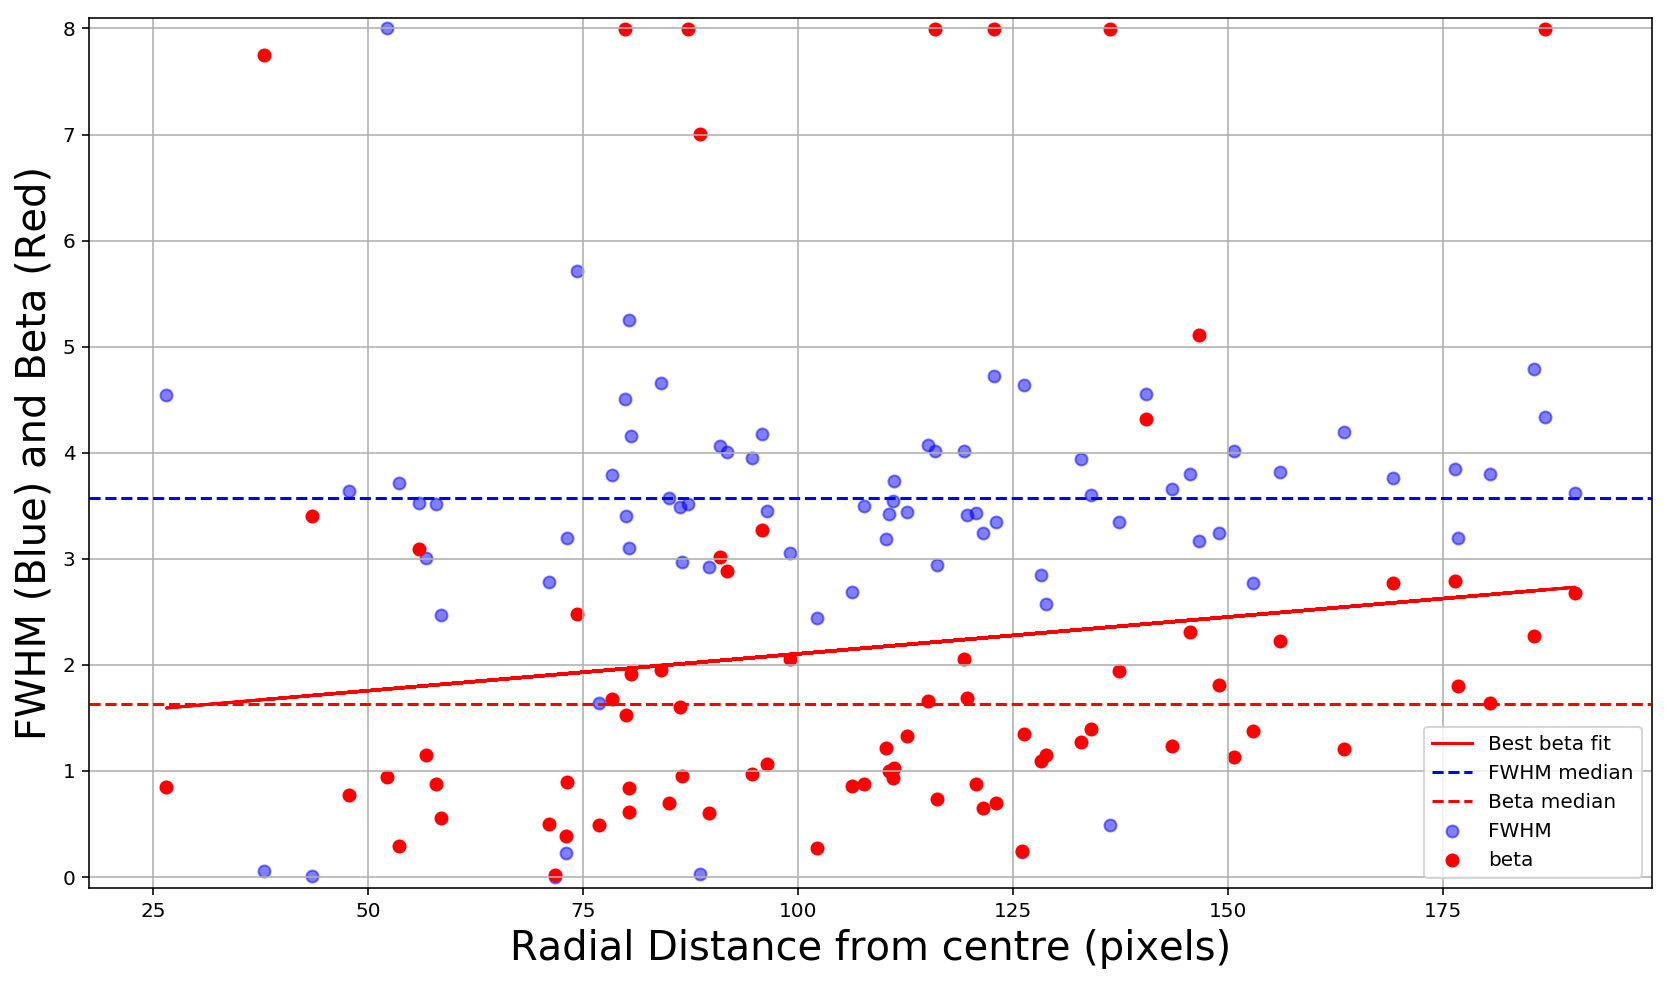

In [34]:
plt.figure(figsize=(14,8))
plt.scatter(rad_sel, fitted_FWHM, label="FWHM", c="blue", alpha=0.5)
plt.scatter(rad_sel, fitted_beta, label="beta", c="red")
plt.plot(rad_sel, (m*rad_sel + c), label="Best beta fit", c="r")
#plt.scatter(rad_sel, fitted_G_FWHM, label="G_FWHM", c="k" )
plt.xlabel("Radial Distance from centre (pixels)", fontsize=20)
plt.ylabel("FWHM (Blue) and Beta (Red)", fontsize=20)
plt.ylim(-0.1,8.1)
plt.grid()

plt.axhline(np.median(fitted_FWHM[:50]), label="FWHM median", ls="dashed", c="blue")
plt.axhline(np.median(fitted_beta[:50]), label="Beta median", ls="dashed", c="red")
#plt.axhline(np.median(fitted_G_FWHM), label="G_FWHM median", ls="dashed", c="k")

print(np.median(fitted_beta[:20]))
print(np.median(fitted_FWHM[:20]))
plt.legend()
plt.savefig("Plots/FCC167/radial_FWHM_beta.png")

# PSF Fitting - Evaluation with differing number of simultaneous PNe fitted

In [18]:
num_psf=10
fitted_FWHM = np.zeros(num_psf)
fitted_beta = np.zeros(num_psf)
A_rN_total = np.zeros(num_psf)
fitted_G_FWHM = np.zeros(num_psf)
fitted_moff_amp = [[]]*num_psf
fitted_x = [[]]*num_psf
fitted_y = [[]]*num_psf

#params = Parameters()
def model_params(p, n, amp, mean):
    PSF_params.add("moffat_amp_{:03d}".format(n), value=amp, min=0.001)
    PSF_params.add("x_{:03d}".format(n), value=n_pixels/2., min=0.001, max=n_pixels)
    PSF_params.add("y_{:03d}".format(n), value=n_pixels/2., min=0.001, max=n_pixels)
    PSF_params.add("mean_{:03d}".format(n), value=mean, min=5000., max=5070.)
    PSF_params.add("gauss_bkg_{:03d}".format(n), value=0.01)
    PSF_params.add("gauss_grad_{:03d}".format(n), value=0.01)
    
for j in np.arange(0, num_psf):
    sel_PNe = PNe_df.nlargest(j+1, "A/rN").index.values
    selected_PNe = PNe_spectra[sel_PNe]
    selected_PNe_err = obj_error_cube[sel_PNe]
    PSF_params = Parameters()
    for i in np.arange(0,len(sel_PNe)):
        model_params(p=PSF_params, n=i, amp=200.0, mean=5035.0)
    PSF_params.add('FWHM', value=3.8, min=0.01, max=12., vary=False)
    PSF_params.add("beta", value=3.0, min=0.01, max=12., vary=True) 
    PSF_params.add("Gauss_FWHM", value=0.0001, min=0.00001, max=3.0, vary=False)
    A_rN_total[j] = np.sqrt(np.sum(PNe_df.iloc[sel_PNe]["A/rN"]**2.))
    A_rN_of_PNe = np.ones(len(sel_PNe))#PNe_df.iloc[sel_PNe]["A/rN"].values
    results = minimize(PSF_residuals, PSF_params, args=(wavelength, x_fit, y_fit, selected_PNe, selected_PNe_err, A_rN_of_PNe), nan_policy="propagate")#, method="differential_evolution")
    fitted_FWHM[j] = results.params["FWHM"].value
    fitted_beta[j] = results.params["beta"].value
    fitted_G_FWHM[j] = results.params["Gauss_FWHM"].value
    #for k in np.arange(0, len(sel_PNe)):
    #    fitted_moff_amp.append(results.params["moffat_amp_{:03d}".format(k)].value)
    #    fitted_x.append(results.params["x_{:03d}".format(k)].value)
    #    fitted_y.append(results.params["y_{:03d}".format(k)].value)

    

3.8
1.37908560862


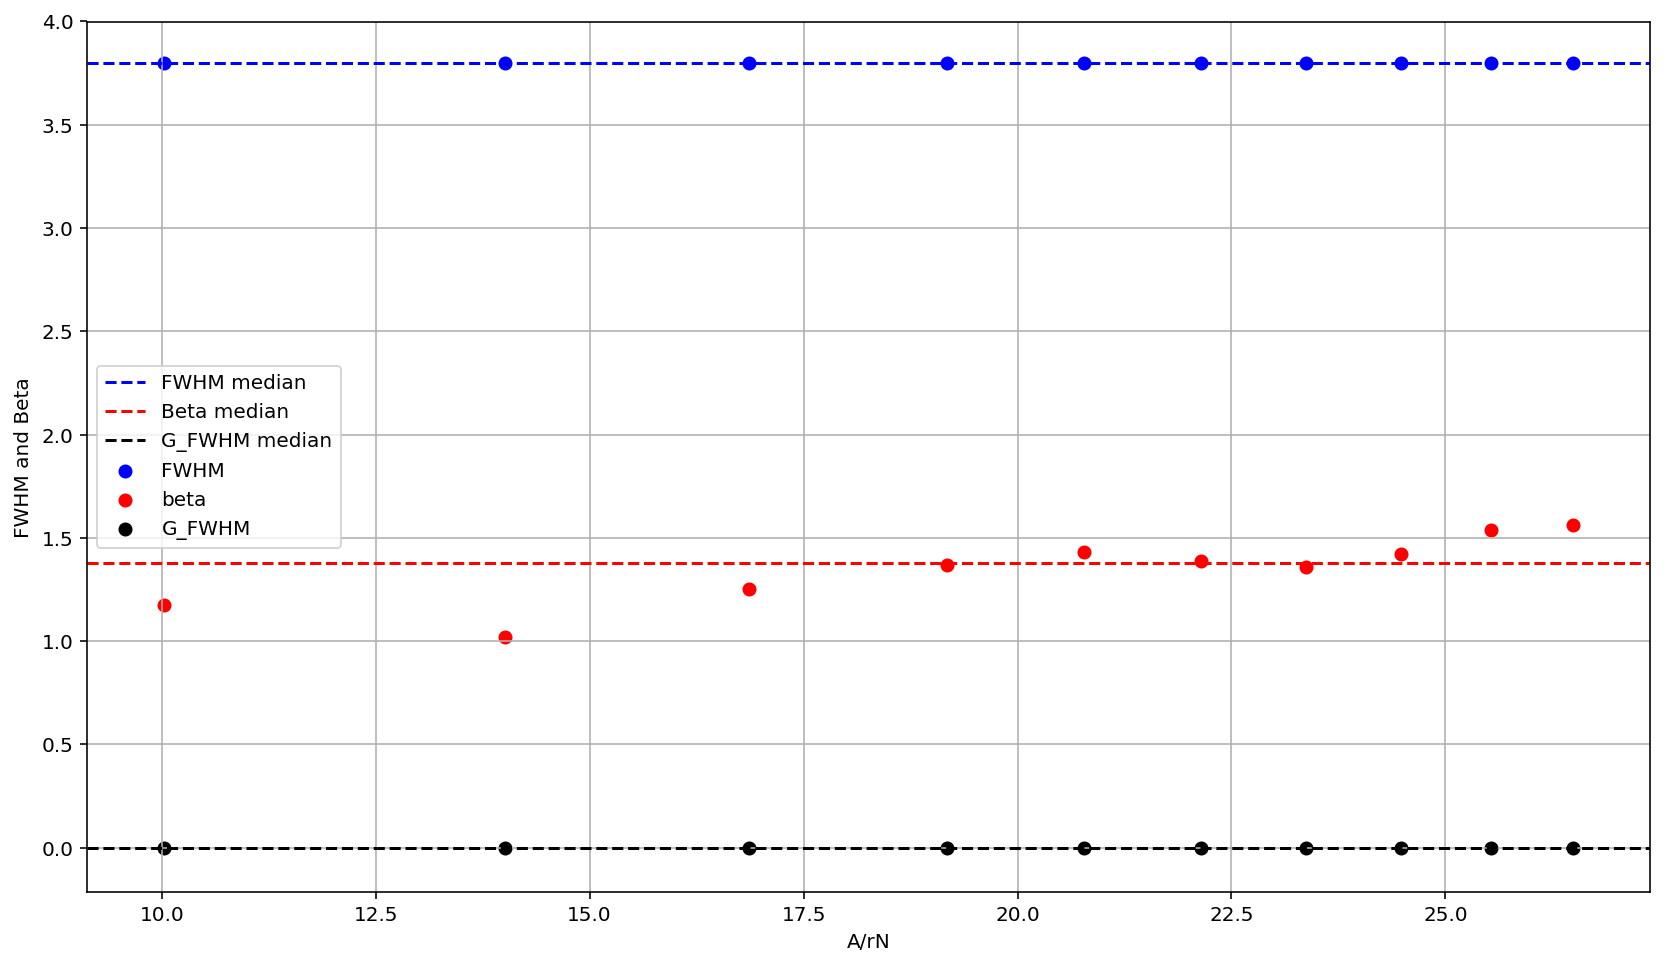

In [19]:
plt.figure(figsize=(14,8))
plt.scatter(A_rN_total, fitted_FWHM, label="FWHM", c="blue")
plt.scatter(A_rN_total, fitted_beta, label="beta", c="red")
plt.scatter(A_rN_total, fitted_G_FWHM, label="G_FWHM", c="k" )
plt.xlabel("A/rN")
plt.ylabel("FWHM and Beta")
plt.grid()

plt.axhline(np.median(fitted_FWHM[:]), label="FWHM median", ls="dashed", c="blue")
plt.axhline(np.median(fitted_beta[:]), label="Beta median", ls="dashed", c="red")
plt.axhline(np.median(fitted_G_FWHM[:]), label="G_FWHM median", ls="dashed", c="k")

print(np.median(fitted_FWHM[:]))
print(np.median(fitted_beta[:]))
      
plt.legend()
#plt.savefig("Plots/FCC167/PSF_A_rN_FWHM_beta.png")

# MCMC PSF fitter

In [51]:
# MCMC
sel_PNe = [25]# PNe_df.nlargest(1, "A/rN").index.values

selected_PNe = PNe_spectra[sel_PNe]
selected_PNe_err = error_cube[sel_PNe] 

PSF_params = Parameters()
def model_params(p, n, amp, mean):
    PSF_params.add("moffat_amp_{:03d}".format(n), value=amp, min=0.001)
    PSF_params.add("x_{:03d}".format(n), value=n_pixels/2., min=0.001, max=n_pixels)
    PSF_params.add("y_{:03d}".format(n), value=n_pixels/2., min=0.001, max=n_pixels)
    PSF_params.add("mean_{:03d}".format(n), value=mean, min=5000., max=5070.)
    PSF_params.add("gauss_bkg_{:03d}".format(n), value=0.001)
    PSF_params.add("gauss_grad_{:03d}".format(n), value=0.001)

for i in np.arange(0,len(sel_PNe)):
        model_params(p=PSF_params, n=i, amp=100.0, mean=5035.0)   
    
PSF_params.add('FWHM', value=4.0, min=0.01, max=12., vary=True)
PSF_params.add("beta", value=4.0, min=0.01, max=12., vary=True) 
PSF_params.add("Gauss_FWHM", value=0.00001, min=0.0000001, max=3.0, vary=False) # LSF, instrumental resolution.

def lnprob(p, data, error):
    noise = p["f"]
    res = PSF_residuals(p, wavelength, x_fit, y_fit, data, error, PNe_df.loc[sel_PNe, "A/rN"].values)
    return -0.5 * np.sum((res / noise)**2 + np.log(2 * np.pi * noise**2))

# add a noise parameter and run MCMC for each run from results_for_MCMC
run_mini = minimize(PSF_residuals, PSF_params, args=(wavelength, x_fit, y_fit, selected_PNe, selected_PNe_err, PNe_df.loc[sel_PNe, "A/rN"].values), nan_policy="propagate")
print("Initial fit complete.")
#add noise parameter
run_mini.params.add('f', value=1., min=0.001, max=2.)
print("Nuisance Parameter added.")
mini_lnprob = Minimizer(lnprob, run_mini.params, fcn_args=(selected_PNe, selected_PNe_err))
print("Minimizer ready.")
# Run MCMC routine
print("All aboard the MCMC train.")
MCMC_results = mini_lnprob.emcee(nwalkers=400, burn=1000, steps=3000, thin=20, workers=6, is_weighted=True, params=run_mini.params)

print("FWHM: " , MCMC_results.params["FWHM"].value, MCMC_results.params["FWHM"].stderr)
print("Beta: " , MCMC_results.params["beta"].value, MCMC_results.params["beta"].stderr)

Initial fit complete.
Nuisance Parameter added.
Minimizer ready.
All aboard the MCMC train.
FWHM:  3.808559855739681 0.9889531491362333
Beta:  2.498122729412981 0.2202446549417667


In [ ]:
report_fit(MCMC_results)